# **Imports**

In [1]:
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import astropy.units as u
from astropy.units import Quantity
from astropy.constants import au
import astropy.units as u
from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = -1
from astropy.coordinates.sky_coordinate import SkyCoord
from google.colab import drive
import pandas as pd
from matplotlib import gridspec
from google.colab import output
from astropy.table import QTable, Table, Column

#import emcee
#from sklearn.mixture import GaussianMixture
#from astroML.decorators import pickle_results
#from astroML.density_estimation import XDGMM

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

label_font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 18,
        }

title_font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'semibold',
        'size': 21,
        }


drive.mount('/content/gdrive')
codefold = "/content/gdrive/MyDrive/Tesi_di_laurea/Codes"                        # Cartella del codice
imfold = '/content/gdrive/MyDrive/Tesi_di_laurea/Immagini'                       # Cartella immagini

class Cluster: # This class contains information about globular cluster
  def __init__(self, s_ra, s_dec, dist, c, r_cd, r_hd, w0):
    self.ra = s_ra * u.deg            # of its centre
    self.dec = s_dec * u.deg          # of its centre
    self.distance = dist * u.kpc       # Baumgardt
    self.concentration = c
    self.r_core_deg = (r_cd*u.arcmin).to(u.deg)#(r_cd/60) * u.deg             # Core radius in Deg        >Imput in arcmin<
    self.r_halflight_deg = (r_hd/60) * u.deg        # Half-light radius in Deg  >Imput in arcmin<
    self.w0 = w0

NGC6121 = Cluster(s_ra=245.8958, s_dec=-26.5256, dist=1.851, c=1.65, r_cd=1.16, r_hd=4.33, w0=7.41)

output.clear()

ModuleNotFoundError: No module named 'google.colab'

In [2]:
def angular_distance(ra0, dec0, ra1, dec1, ra0_err, dec0_err, corr):
    '''
    Compute the angular distance between two points on a sphere (coordinates expressed in degrees)
    and it's computed error through the propagation formula.
    '''
    d2r = np.pi/180  # degrees to radians
    w = 2 * np.arcsin( (np.sin( (dec0-dec1)*0.5 * d2r )**2 +
        np.cos(dec0 * d2r) * np.cos(dec1 * d2r) * np.sin( (ra0-ra1)*0.5 * d2r )**2 )**0.5 ) / d2r

    Omega = np.sin(1/2 * w * d2r)
    denom = 1/np.sqrt(Omega**2 - Omega)

    par_x = denom**2 * np.sin((ra0-ra1)*d2r)*np.cos(dec0*d2r)*np.cos(dec1*d2r)
    par_y = denom**2 * (np.sin((dec0-dec1)*d2r) - 2*np.sin(dec0*d2r)*np.cos(dec1*d2r)*np.sin((ra0-ra1)*0.5*d2r)**2)

    we = np.sqrt((par_x*ra0_err)**2 + (par_y*dec0_err)**2 + par_x*par_y*ra0_err*dec0_err*corr) / d2r

    return w, we

def bins_(N):
  '''
  Compute the optimal number of bins for a given sample, that is N_bin=1.5*sqrt(N)
  '''
  return int(1.5*np.sqrt(N))

# NGC 6121 lower distribution

Prendiamo un sample raw, ovvero facciamo uno scan circolare del cielo di raggio R=0.19333° coordinate centrali RA:245.8958° DEC: -26.5256°. Quessto sample deve essere ripulito da stelle di campo, crowding e parallassi inaffidabili.

In [2]:
job = Gaia.launch_job_async("SELECT source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, radial_velocity, radial_velocity_error, bp_rp, phot_rp_mean_mag, phot_bp_mean_mag \
                            FROM gaiadr3.gaia_source \
                            WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.8958,-26.5256,0.2))=1 \
                            AND parallax IS NOT NULL \
                            AND parallax>0")

NGC6121 = Cluster(s_ra=245.8958, s_dec=-26.5256, dist=1.851, c=1.65, r_cd=1.16, r_hd=4.33, w0=7.41)
B_px = 1/NGC6121.distance.value # mas

n6121 = job.get_results()
print(" Sample number of objects: {:d}".format(len(n6121)))

fig, (ax0, ax1) = plt.subplots(ncols=2,nrows=1,figsize=(18,8))
ax0.scatter(n6121['ra'], n6121['dec'], color='black', alpha=0.35, marker='.', s=1)
ax0.set_title("Position of stars in the Sky", fontdict=title_font)
ax1.set_ylim(-40,20)
ax1.set_xlim(-50,35)
ax0.set_xlabel("RA", fontdict=label_font)
ax0.set_ylabel("DEC", fontdict=label_font)
ax1.scatter(n6121['pmra'], n6121['pmdec'], color='black', alpha=0.35, s=1)
ax1.set_title("Proper motion of the objects", fontdict=title_font)
ax1.set_xlabel("pmRA", fontdict=label_font)
ax1.set_ylabel("pmDEC", fontdict=label_font)
ax0.axis('equal')

INFO: Query finished. [astroquery.utils.tap.core]


NameError: name 'Cluster' is not defined

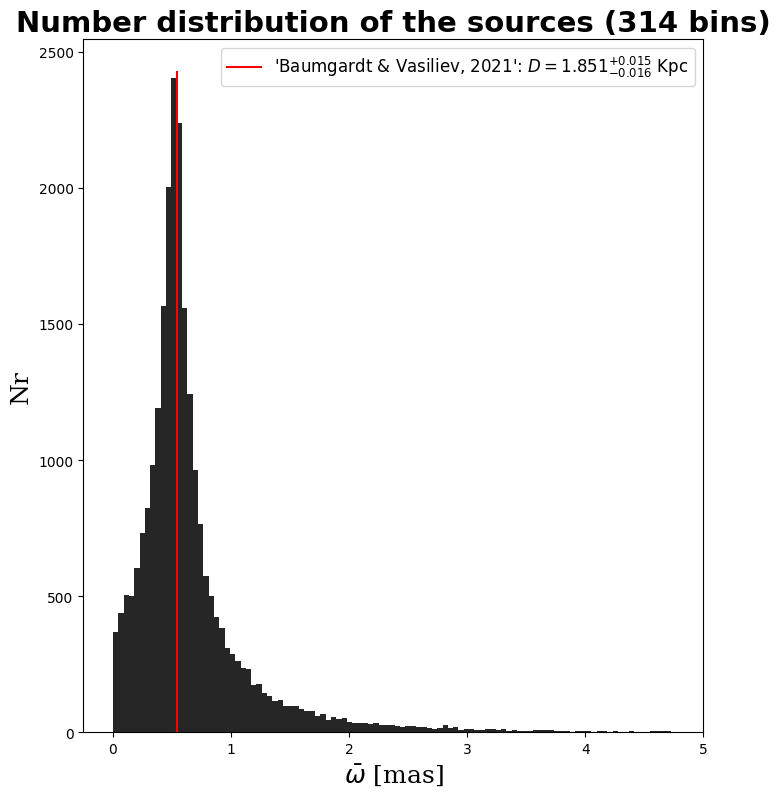

In [ ]:
plt.figure(figsize=(8,9))
px_d4 = plt.hist(n6121['parallax'], bins=int(2*np.sqrt(len(n6121))), color='black', alpha=0.85)
plt.legend(loc='best', fontsize='large')
plt.plot([1/1.851, 1/1.851],[0, np.max(px_d4[0]) +20], c='red', label= r"'Baumgardt & Vasiliev, 2021': $D=1.851^{+0.015}_{-0.016}$ Kpc")
plt.xlim(-0.25, 5)
plt.xlabel(r"$\bar{\omega}$ [mas]", fontdict=label_font)
plt.ylabel("Nr", fontdict=label_font)
plt.title("Number distribution of the sources ({:d} bins)".format(int(2*np.sqrt(len(n6121)))), fontdict=title_font)
plt.legend(loc='best', fontsize='large')
plt.show()

Distribuzione spaziale intorno al centro del sample raccolto

A questo punto, dopo varie prove, si trova lo sweet spot di pulizia di dati vs perdita del N di oggetti. Si fa dunque una scansione con le stesse caratteristiche della precedente, in cui si sono poste condizioni sugli errori percentuali di $\bar{\omega}$, *pmRA* e *pmDEC*. È stata inoltre fatta, in questo specifico caso, una selezione accurata del range di proper motion dovuto al fatto che come si vede nei pannelli precedenti, nello spazio del pm appaiono due distribuzioni diverse. È stata selezionata quella le cui parallassi fossero maggiormente compatibili con la distanza ricavata da "Baumgardt & Vasiliev, 2021", ovvero $D_{NGC6121} = 1.851^{+0.015}_{-0.016}$

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
 Sample number of objects: 10823


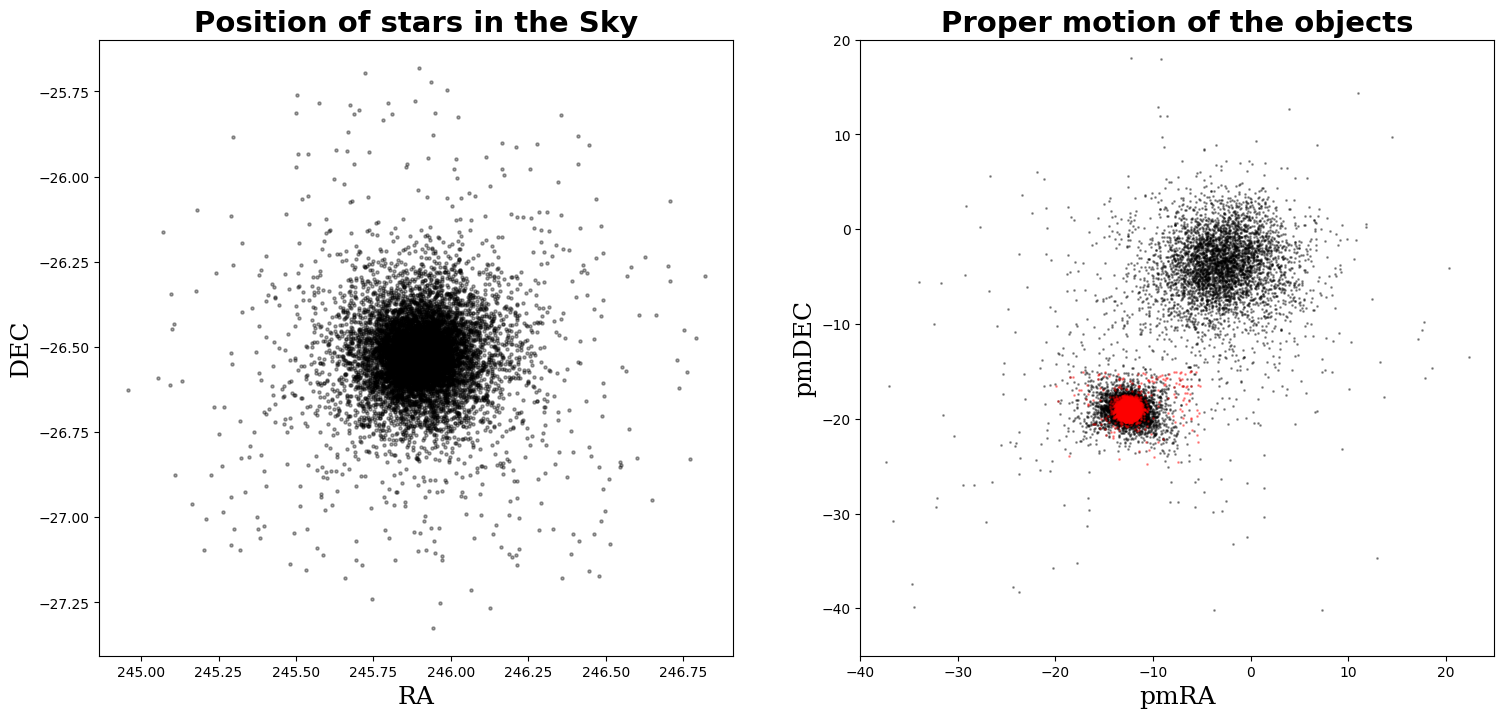

In [ ]:
job2 = Gaia.launch_job_async("SELECT source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, radial_velocity, radial_velocity_error \
                            FROM gaiadr3.gaia_source \
                            WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.8958,-26.5256,0.86))=1 \
                            AND parallax IS NOT NULL AND parallax>0 AND parallax<1.0\
                            AND abs(parallax_error/parallax)<0.30\
                            AND abs(pmra_error/pmra)<0.10 \
                            AND abs(pmdec_error/pmdec)<0.10 \
                            AND pmra IS NOT NULL AND abs(pmra)>0 \
                            AND pmdec IS NOT NULL AND abs(pmdec)>0 \
                            AND pmra BETWEEN -20 AND -5 \
                            AND pmdec BETWEEN -25 AND -15")
#ra:-20 -5; dec -25 -10
n6121_r = job2.get_results()
print(" Sample number of objects: {:d}".format(len(n6121_r)))

fig, (ax0, ax1) = plt.subplots(ncols=2,nrows=1,figsize=(18,8))
ax0.scatter(n6121_r['ra'], n6121_r['dec'], color='black', alpha=0.35, s=5)
ax0.set_title("Position of stars in the Sky", fontdict=title_font)
ax0.set_xlabel("RA", fontdict=label_font)
ax0.set_ylabel("DEC", fontdict=label_font)
ax1.scatter(n6121['pmra'], n6121['pmdec'], color='black', alpha=0.35, s=1)
ax1.scatter(n6121_r['pmra'], n6121_r['pmdec'], color='red', alpha=0.35, s=1)
ax1.set_title("Proper motion of the objects", fontdict=title_font)
ax1.set_xlabel("pmRA", fontdict=label_font)
ax1.set_ylabel("pmDEC", fontdict=label_font)
ax1.set_xlim(-40,25)
ax1.set_ylim(-45,20)

n_bin1 = int((np.sqrt(len(n6121_r)) + 2*np.sqrt(len(n6121_r)))/2)

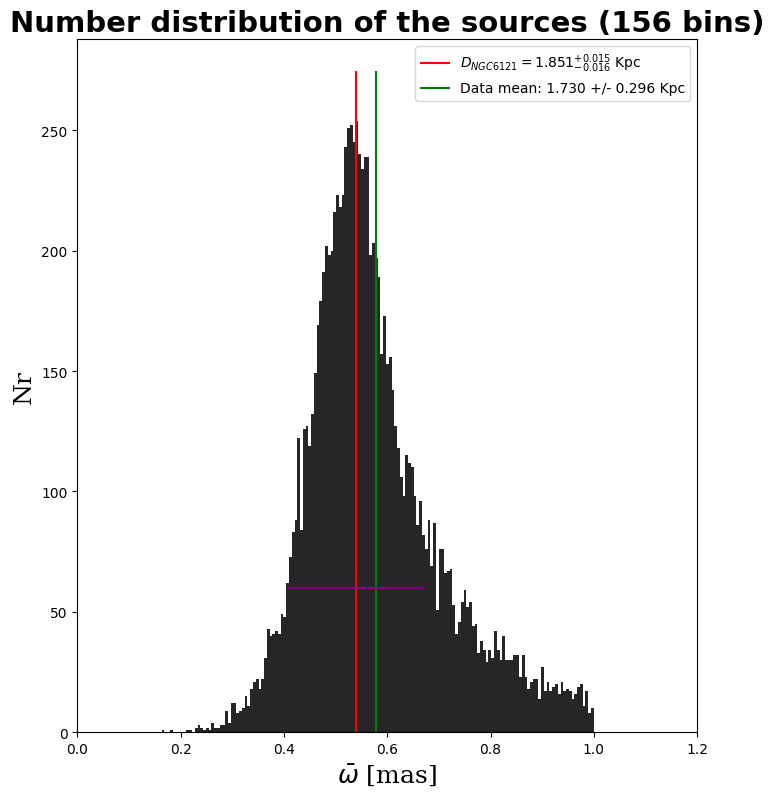

 Mean Px: 0.57808 +/- 0.09894 Kpc
 Px std: 0.13120


In [ ]:
stdev_n6121_r = np.std(n6121_r['parallax'])
mean_n6121_r = np.mean(n6121_r['parallax'])
err_mean = np.mean(n6121_r['parallax_error'])
mean_px_err = 1/mean_n6121_r**2 * err_mean

n6121_distance = 1.851 # Kpc

plt.figure(figsize=(8,9))
px_d4 = plt.hist(n6121_r['parallax'], bins=n_bin1, color='black', alpha=0.85)
plt.plot([1/1.851, 1/1.851],[0, np.max(px_d4[0]) +20], c='red', label= r"$D_{NGC6121}=1.851^{+0.015}_{-0.016}$ Kpc")
plt.plot([mean_n6121_r, mean_n6121_r],[0, np.max(px_d4[0]) +20], c='green', label= "Data mean: {:.3f} +/- {:.3f} Kpc".format(1/mean_n6121_r, mean_px_err))
plt.plot([1/1.851 - stdev_n6121_r, 1/1.851 + stdev_n6121_r], [60,60], c='purple')
plt.legend(loc='best', fontsize='medium')
plt.xlim(0, 1.2)
plt.xlabel(r"$\bar{\omega}$ [mas]", fontdict=label_font)
plt.ylabel("Nr", fontdict=label_font)
plt.title("Number distribution of the sources ({:d} bins)".format(n_bin1), fontdict=title_font)
plt.show()
print(" Mean Px: {:.5f} +/- {:.5f} Kpc\n Px std: {:.5f}".format(mean_n6121_r, err_mean, stdev_n6121_r))

A questo punto facciamo un'ulteriore pulizia delle parallassi, tenendo solamente le parallassi entro una deviazione standard dal valore atteso $D_{NGC6121}$

px_m = 0.538 +- 0.892 mas
err = 166.02 %
rx_m = 1.86 +- 3.09 kpc  (con errore settato al 17%)
rx_m = 1.86 +- 0.34 kpc  (con errore calcolato con la solita formula)


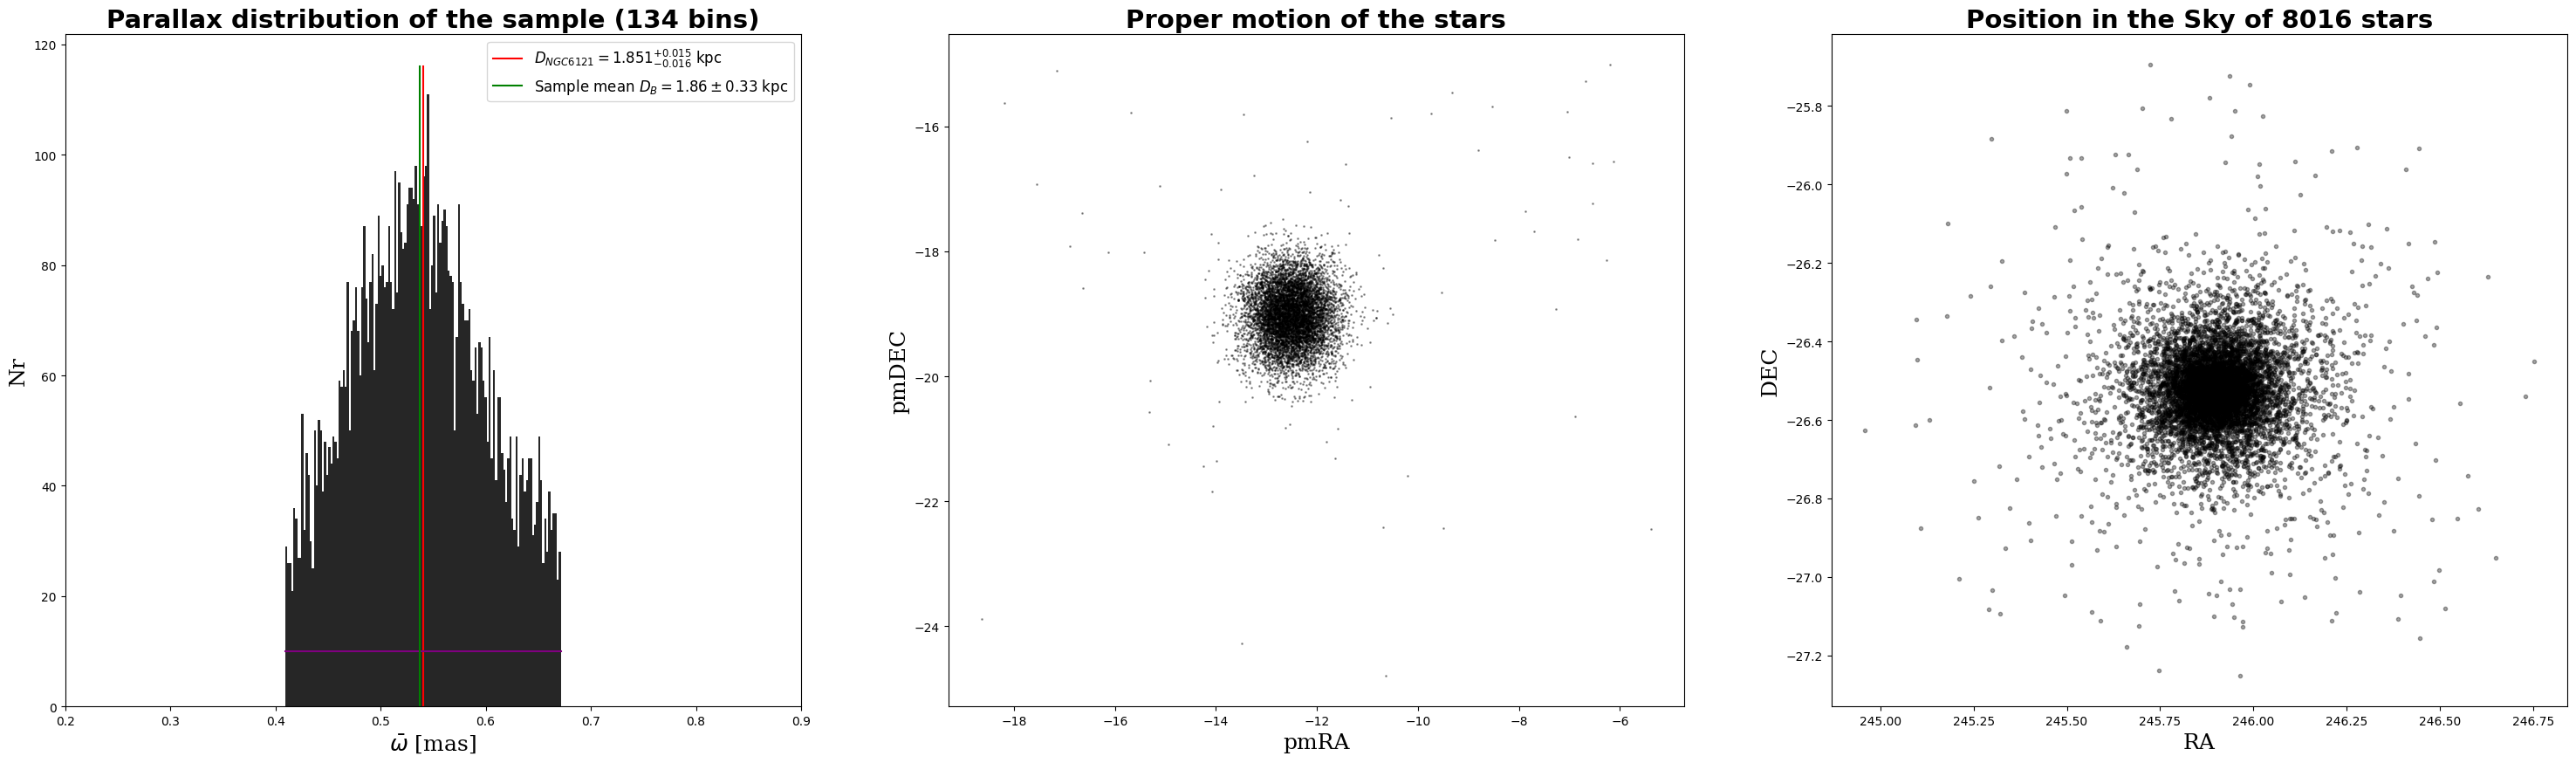

In [ ]:
min_px = 1/n6121_distance - stdev_n6121_r
max_px= 1/n6121_distance + stdev_n6121_r

i=0
for x in range (0, len(n6121_r)):
  if (n6121_r['parallax'][x] > min_px and n6121_r['parallax'][x] < max_px):
    i += 1

n6121_clean = np.zeros((13,i))
j=0
for x in range (0, len(n6121_r)):
  if (n6121_r['parallax'][x] > min_px and n6121_r['parallax'][x] < max_px):
    n6121_clean[0][j] = n6121_r['source_id'][x]
    n6121_clean[1][j] = n6121_r['parallax'][x]
    n6121_clean[2][j] = n6121_r['parallax_error'][x]
    n6121_clean[3][j] = n6121_r['ra'][x]
    n6121_clean[4][j] = n6121_r['ra_error'][x]
    n6121_clean[5][j] = n6121_r['dec'][x]
    n6121_clean[6][j] = n6121_r['dec_error'][x]
    n6121_clean[7][j] = n6121_r['pmra'][x]
    n6121_clean[8][j] = n6121_r['pmra_error'][x]
    n6121_clean[9][j] = n6121_r['pmdec'][x]
    n6121_clean[10][j] = n6121_r['pmdec_error'][x]
    n6121_clean[11][j] = n6121_r['radial_velocity'][x]
    n6121_clean[12][j] = n6121_r['radial_velocity_error'][x]
    j += 1

n_bin1_2 = bins_(len(n6121_clean[0]))
r_x = 1/n6121_clean[1]
rx_m = 1/np.mean(n6121_clean[1])
px_m = 1/rx_m
px_e = np.sqrt(sum(i*i for i in n6121_clean[2])/np.sqrt(len(n6121_clean[2])))
rx_e = 1/(n6121_clean[1]**2) * n6121_clean[2]
rxm_e = np.sqrt(sum((i*i) for i in rx_e))/np.sqrt(len(r_x))

fig, (ax0,ax1,ax2) = plt.subplots(ncols=3, nrows=1 ,figsize=(37,10))
c_px4 = ax0.hist(n6121_clean[1], bins=n_bin1_2, alpha=0.85, color='black')
ax0.plot([1/1.851, 1/1.851],[0, np.max(c_px4[0]) + 5], c='red', label= r"$D_{NGC 6121}=1.851^{+0.015}_{-0.016}$ kpc")
ax0.plot([1/1.851 - stdev_n6121_r, 1/1.851 + stdev_n6121_r], [10,10], c='purple')
ax0.plot([1/rx_m, 1/rx_m], [0, np.max(c_px4[0]) + 5], c='green', label=r"Sample mean $D_B=1.86\pm0.33$ kpc")
ax0.legend(loc='best', fontsize='large')
ax0.set_xlim(0.2, 0.9)
ax0.set_ylabel("Nr", fontdict=label_font)
ax0.set_xlabel(r"$\bar{\omega}$ [mas]", fontdict=label_font)
ax0.set_title("Parallax distribution of the sample ({:d} bins)".format(n_bin1_2), fontdict=title_font)

ax2.scatter(n6121_clean[3], n6121_clean[5], color='black', marker='.', alpha=0.35)
ax2.set_title("Position in the Sky of {:d} stars".format(len(n6121_clean[0])), fontdict=title_font)
ax2.set_xlabel("RA", fontdict=label_font)
ax2.set_ylabel("DEC", fontdict=label_font)
ax1.scatter(n6121_clean[7], n6121_clean[9], color='black', alpha=0.35, s=1)
ax1.set_title("Proper motion of the stars", fontdict=title_font)
ax1.set_xlabel("pmRA", fontdict=label_font)
ax1.set_ylabel("pmDEC", fontdict=label_font)

print('px_m = {:.3f} +- {:.3f} mas'.format(px_m, px_e))
print('err = {:.2f} %'.format(100*px_e/px_m))
print('rx_m = {:.2f} +- {:.2f} kpc  (con errore settato al 17%)'.format(rx_m, rx_m*(px_e/px_m)))
print('rx_m = {:.2f} +- {:.2f} kpc  (con errore calcolato con la solita formula)'.format(rx_m, rxm_e))

La media della distanza è stata calcolata in due modi

> $\big<r_x\big> = \frac{1}{N}\sum_{i=1}^N r_{x,i}$

ovvero la classica media, dove $r_x = 1/\bar{\omega}$.

> $\bar{r_x} = \frac{1}{\big<\bar{\omega}\big>}=\frac{N}{\sum_{i}^N \bar{\omega}_i}$

ovvero come 1 sulla media elle parallassi.
Anche l'errore lo calcoliamo in due modi. Il primo è calcolando l'errore della parallasse media, con la formula

> $\varepsilon_\omega = \frac{\sum_i^N ɛ^2_i}{N}$

e calcolando poi l'errore relativo

> $\epsilon = \frac{\big<\bar{\omega}\big>}{\varepsilon(\omega)}$

Il econdo modo è utilizzando, anche qui, la formula

> $\big<r_x\big> = \frac{\sum_i^N ɛ^2_i}{\sqrt{N}}$

Infine, per ragioni di comodità a livello di lavoro con i dati, si performa una query finale dove si prendono solamente gli oggetti con le caratteristiche finora mantenute.

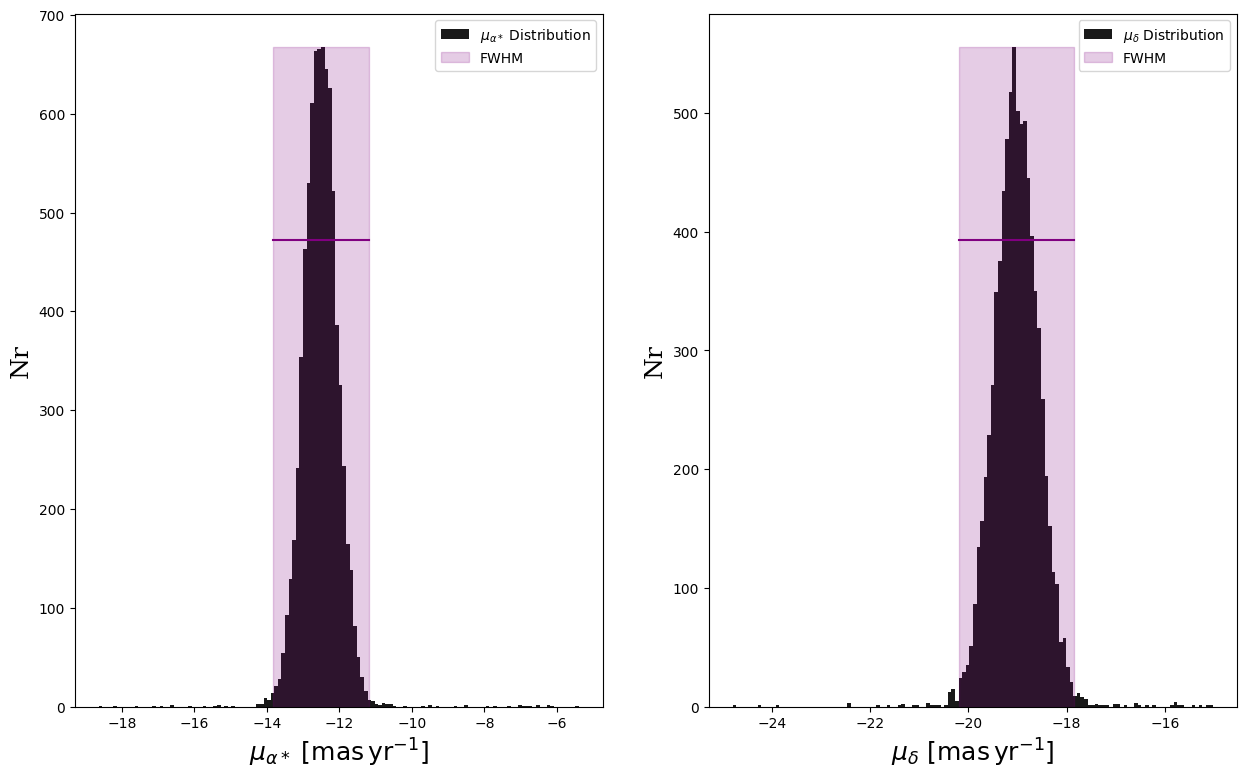

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,9))
h1 = axs[0].hist(n6121_clean[7], bins=n_bin1_2, color='black', alpha=0.9, label=r'$\mu_{\alpha*}$ Distribution')
axs[0].plot([np.mean(n6121_clean[7]) - 2.355*np.std(n6121_clean[7]),np.mean(n6121_clean[7]) + 2.355*np.std(n6121_clean[7]) ], [0.7071*np.max(h1[0]), 0.7071*np.max(h1[0])], c='purple')
axs[0].fill_between([np.mean(n6121_clean[7]) - 2.355*np.std(n6121_clean[7]),np.mean(n6121_clean[7]) + 2.355*np.std(n6121_clean[7]) ], 0, np.max(h1[0]), color='purple',alpha=0.2, label="FWHM")
axs[0].set_xlabel(r'$\mu_{\alpha*}$ $[{\rm mas\,yr^{-1}}]$', fontdict=label_font)
axs[0].set_ylabel('Nr', fontdict=label_font)
h2 = axs[1].hist(n6121_clean[9], bins=n_bin1_2, color='black', alpha=0.9, label=r'$\mu_{\delta}$ Distribution')
axs[1].plot([np.mean(n6121_clean[9]) - 2.355*np.std(n6121_clean[9]),np.mean(n6121_clean[9]) + 2.355*np.std(n6121_clean[9]) ], [0.7071*np.max(h2[0]), 0.7071*np.max(h2[0])], c='purple')
axs[1].fill_between([np.mean(n6121_clean[9]) - 2.355*np.std(n6121_clean[9]),np.mean(n6121_clean[9]) + 2.355*np.std(n6121_clean[9]) ], 0, np.max(h2[0]), color='purple',alpha=0.2, label="FWHM")
axs[1].legend()
axs[1].set_xlabel(r'$\mu_{\delta}$ $[{\rm mas\,yr^{-1}}]$', fontdict=label_font)
axs[1].set_ylabel('Nr', fontdict=label_font)
axs[0].legend()
plt.show()

Max: pmra=-11.2049 mas/yr   pmdec=-17.8555 mas/yr
Min: pmra=-13.8282 mas/yr   pmdec=-20.1822 mas/yr

Clean
Min px    = 0.409136 ; Max px    = 0.671421
Min pmRA  = -13.821962 ; Max pmRA  = -11.208192
Min pmDEC = -20.179998 ; Max pmDEC = -17.867315


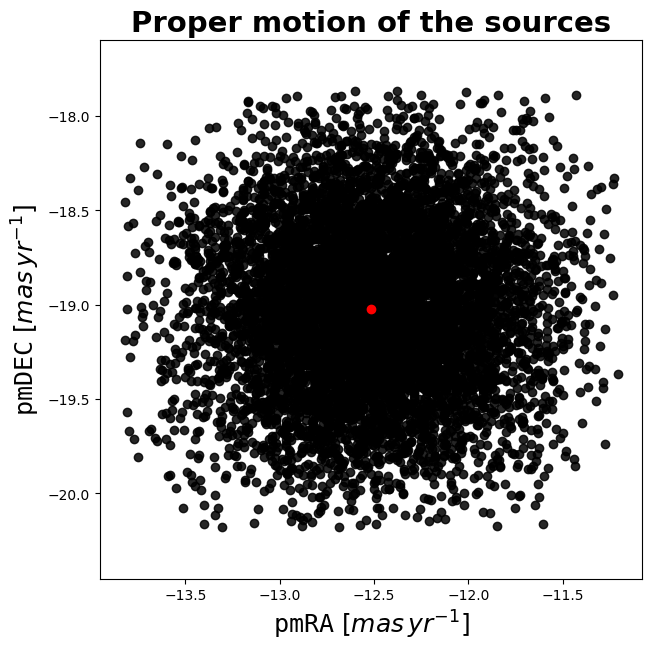

In [ ]:
pmra_max = np.mean(n6121_clean[7]) + 2.335*np.std(n6121_clean[7])
pmra_min = np.mean(n6121_clean[7]) - 2.355*np.std(n6121_clean[7])

i=0
for x in range (0, len(n6121_clean[7])):
  if (n6121_clean[7][x] < pmra_max and n6121_clean[7][x] > pmra_min):
    i += 1

n6121_clean2 = np.zeros((13,i))
j=0
for x in range (0, len(n6121_clean[7])):
  if (n6121_clean[7][x] < pmra_max and n6121_clean[7][x] > pmra_min):
    n6121_clean2[0][j] = n6121_clean[0][x]
    n6121_clean2[1][j] = n6121_clean[1][x]
    n6121_clean2[2][j] = n6121_clean[2][x]
    n6121_clean2[3][j] = n6121_clean[3][x]
    n6121_clean2[4][j] = n6121_clean[4][x]
    n6121_clean2[5][j] = n6121_clean[5][x]
    n6121_clean2[6][j] = n6121_clean[6][x]
    n6121_clean2[7][j] = n6121_clean[7][x]
    n6121_clean2[8][j] = n6121_clean[8][x]
    n6121_clean2[9][j] = n6121_clean[9][x]
    n6121_clean2[10][j] = n6121_clean[10][x]
    n6121_clean2[11][j] = n6121_clean[11][x]
    n6121_clean2[12][j] = n6121_clean[12][x]
    j += 1

pmdec_max = np.mean(n6121_clean[9]) + 2.355*np.std(n6121_clean[9])
pmdec_min = np.mean(n6121_clean[9]) - 2.355*np.std(n6121_clean[9])


k=0
for x in range (0, len(n6121_clean2[9])):
  if (n6121_clean2[9][x] < pmdec_max and n6121_clean2[9][x] > pmdec_min):
    k += 1

n6121_clean3 = np.zeros((13,k))
l=0
for x in range (0, len(n6121_clean2[9])):
  if (n6121_clean2[9][x] < pmdec_max and n6121_clean2[9][x] > pmdec_min):
    n6121_clean3[0][l] = n6121_clean2[0][x]
    n6121_clean3[1][l] = n6121_clean2[1][x]
    n6121_clean3[2][l] = n6121_clean2[2][x]
    n6121_clean3[3][l] = n6121_clean2[3][x]
    n6121_clean3[4][l] = n6121_clean2[4][x]
    n6121_clean3[5][l] = n6121_clean2[5][x]
    n6121_clean3[6][l] = n6121_clean2[6][x]
    n6121_clean3[7][l] = n6121_clean2[7][x]
    n6121_clean3[8][l] = n6121_clean2[8][x]
    n6121_clean3[9][l] = n6121_clean2[9][x]
    n6121_clean3[10][l] = n6121_clean2[10][x]
    n6121_clean3[11][l] = n6121_clean2[11][x]
    n6121_clean3[12][l] = n6121_clean2[12][x]
    l += 1


fig, ax = plt.subplots(figsize=(7,7))
plt.scatter(n6121_clean3[7], n6121_clean3[9], color='black', alpha=0.85)
plt.scatter(np.mean(n6121_clean3[7]), np.mean(n6121_clean3[9]), color='red')
plt.title(r'Proper motion of the sources', fontdict=title_font)
plt.xlabel(r'$\mathtt{pmRA}$ $[mas\,yr^{-1}]$', fontdict=label_font)
plt.ylabel(r'$\mathtt{pmDEC}$ $[mas\,yr^{-1}]$', fontdict=label_font)
ax.axis('equal')

print("Max: pmra={:.4f} mas/yr   pmdec={:.4f} mas/yr\nMin: pmra={:.4f} mas/yr   pmdec={:.4f} mas/yr\n".format(pmra_max, pmdec_max, pmra_min, pmdec_min))
print('Clean\nMin px    = {:f} ; Max px    = {:f}'.format(np.min(n6121_clean3[1]), np.max(n6121_clean3[1])))
print('Min pmRA  = {:f} ; Max pmRA  = {:f}'.format(np.min(n6121_clean3[7]), np.max(n6121_clean3[7])))
print('Min pmDEC = {:f} ; Max pmDEC = {:f}'.format(np.min(n6121_clean3[9]), np.max(n6121_clean3[9])))

# NGC 6121 upper distribution

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
 Sample number of objects: 2294


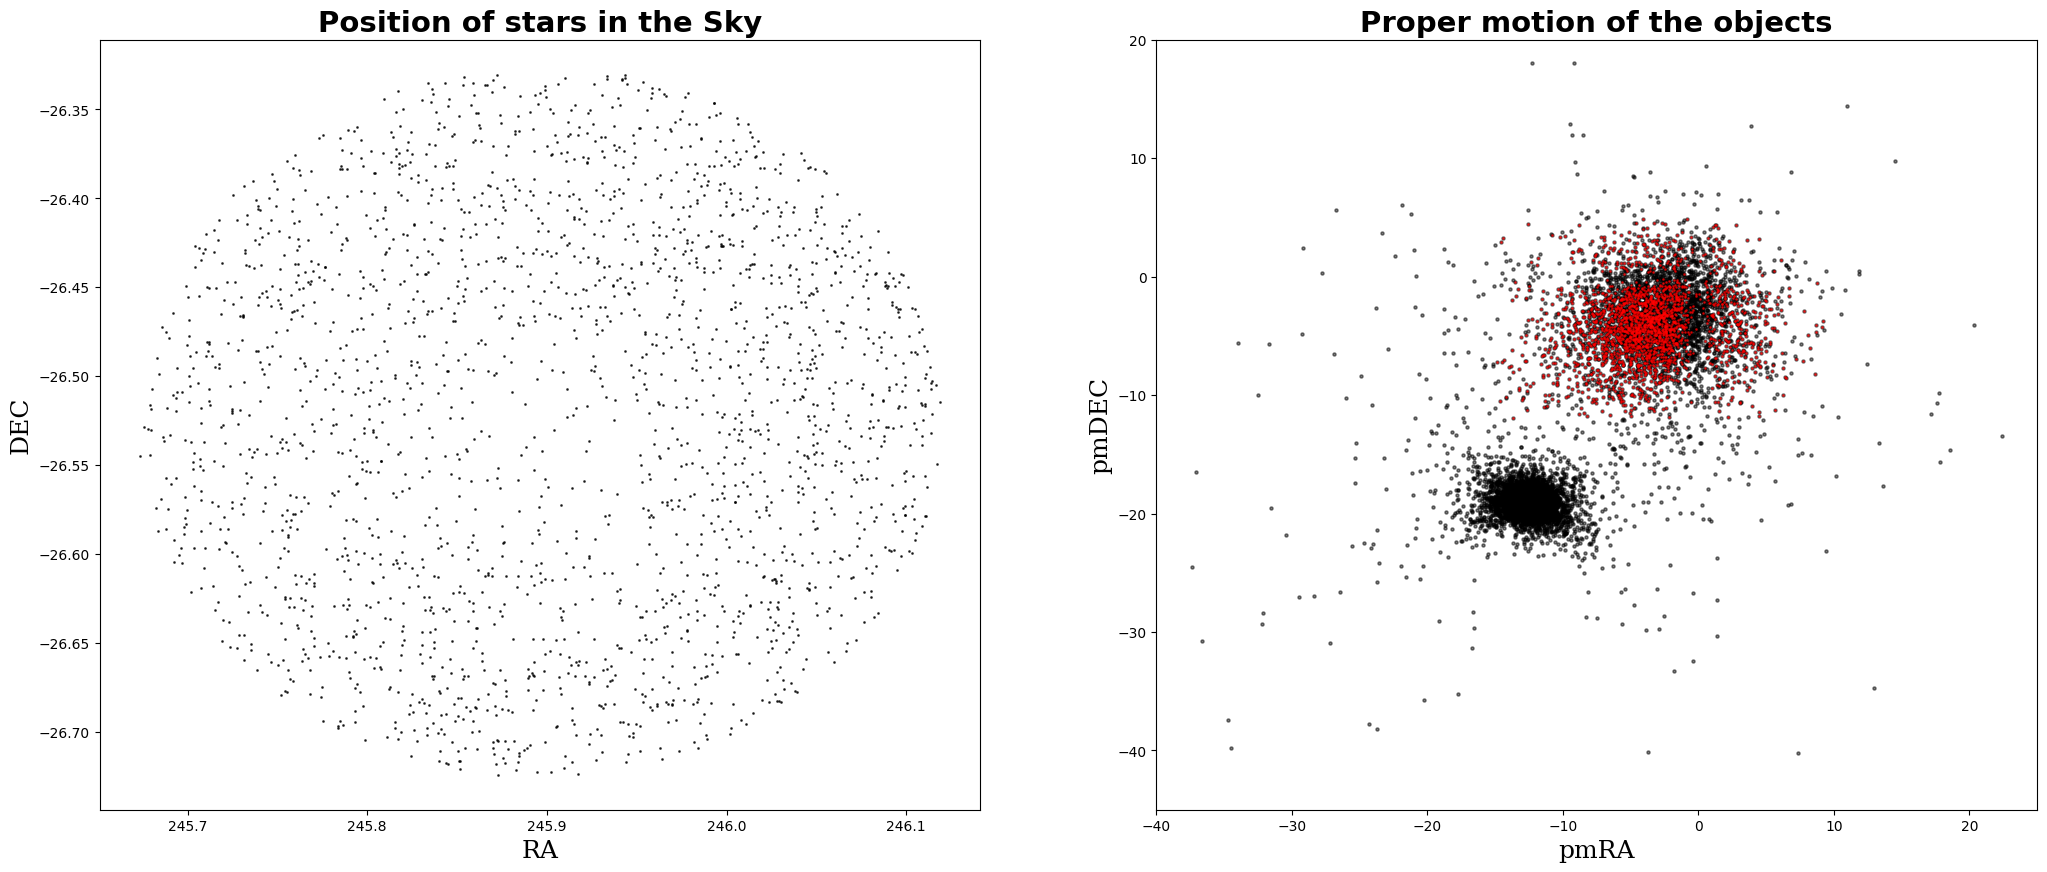

In [ ]:
job2 = Gaia.launch_job_async("SELECT source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, radial_velocity, radial_velocity_error \
                            FROM gaiadr3.gaia_source \
                            WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.8958,-26.5256,0.2))=1 \
                            AND parallax IS NOT NULL AND parallax>0 AND parallax<1 \
                            AND abs(pmra_error/pmra)<0.30 \
                            AND abs(pmdec_error/pmdec)<0.30 \
                            AND pmra IS NOT NULL AND abs(pmra)>0 \
                            AND pmdec IS NOT NULL AND abs(pmdec)>0 \
                            AND pmra BETWEEN -15 AND 10 \
                            AND pmdec BETWEEN -12 AND 5")
#ra:-20 -5; dec -25 -10
n6121_u = job2.get_results()
print(" Sample number of objects: {:d}".format(len(n6121_u)))

fig, (ax0, ax1) = plt.subplots(ncols=2,nrows=1,figsize=(25,10))
ax0.scatter(n6121_u['ra'], n6121_u['dec'], color='black', alpha=0.7, s=1)
ax0.set_title("Position of stars in the Sky", fontdict=title_font)
ax0.set_xlabel("RA", fontdict=label_font)
ax0.set_ylabel("DEC", fontdict=label_font)
ax1.scatter(n6121['pmra'], n6121['pmdec'], color='black', alpha=0.5, s=5)
ax1.scatter(n6121_u['pmra'], n6121_u['pmdec'], color='red', alpha=0.6, s=1)
ax1.set_title("Proper motion of the objects", fontdict=title_font)
ax1.set_xlabel("pmRA", fontdict=label_font)
ax1.set_ylabel("pmDEC", fontdict=label_font)
ax1.set_xlim(-40,25)
ax1.set_ylim(-45,20)

n_bin2 = int( (np.sqrt(len(n6121_u)) + 2*np.sqrt(len(n6121_u)))/2 )

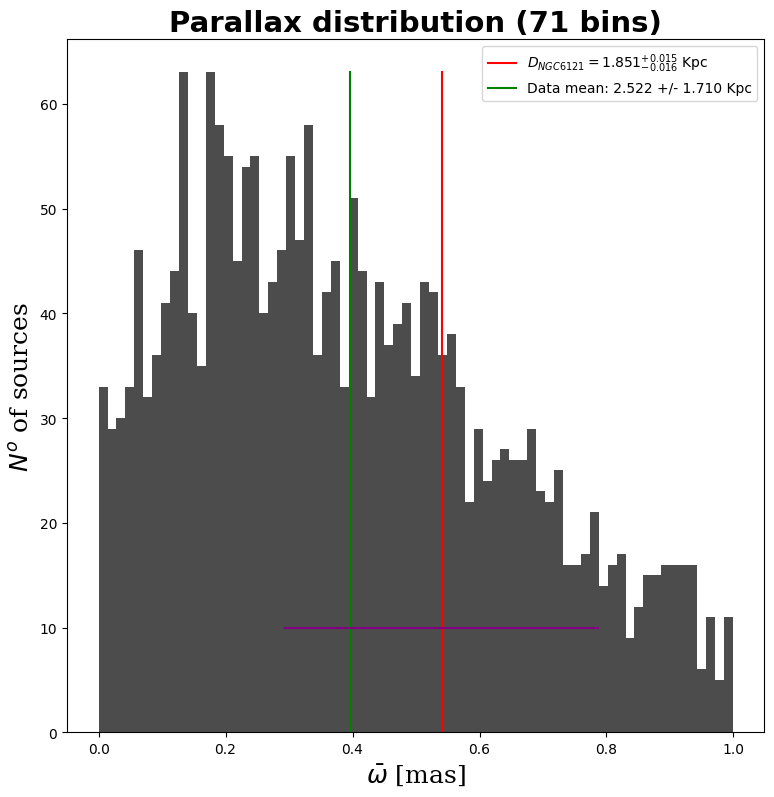

In [ ]:
stdev_n6121_u = np.std(n6121_u['parallax'])
mean_n6121_u = np.mean(n6121_u['parallax'])
temp_merru = np.mean(n6121_u['parallax_error'])
n61c_mean_dist_err =  (1/mean_n6121_u**2) * temp_merru

n6121_distance = 1.851 # Kpc

plt.figure(figsize=(9,9))
px_d4 = plt.hist(n6121_u['parallax'], bins=n_bin2, color='black', alpha=0.7)
plt.plot([1/1.851, 1/1.851],[0, np.max(px_d4[0])], c='red', label= r"$D_{NGC6121}=1.851^{+0.015}_{-0.016}$ Kpc")
plt.plot([mean_n6121_u, mean_n6121_u],[0, np.max(px_d4[0])], c='green', label= "Data mean: {:.3f} +/- {:.3f} Kpc".format(1/mean_n6121_u, n61c_mean_dist_err))
plt.plot([1/1.851 - stdev_n6121_u, 1/1.851 + stdev_n6121_u], [10,10], c='purple')
plt.legend(loc='best')
#plt.xlim(0, 1.4)
plt.xlabel(r"$\bar{\omega}$ [mas]", fontdict=label_font)
plt.ylabel(r"$N^o$ of sources", fontdict=label_font)
plt.title("Parallax distribution ({:d} bins)".format(n_bin2), fontdict=title_font)
plt.show()


A questo punto facciamo un'ulteriore pulizia delle parallassi, tenendo solamente le parallassi entro una deviazione standard dal valore atteso $D_{NGC6121}$

In [ ]:
min_px = 1/n6121_distance - stdev_n6121_u
max_px= 1/n6121_distance + stdev_n6121_u

i=0
for x in range (0, len(n6121_u)):
  if (n6121_u['parallax'][x] > min_px and n6121_u['parallax'][x] < max_px):
    i += 1

n6121u_clean = np.zeros((13,i))
j=0
for x in range (0, len(n6121_u)):
  if (n6121_u['parallax'][x] > min_px and n6121_u['parallax'][x] < max_px):
    n6121u_clean[0][j] = n6121_u['source_id'][x]
    n6121u_clean[1][j] = n6121_u['parallax'][x]
    n6121u_clean[2][j] = n6121_u['parallax_error'][x]
    n6121u_clean[3][j] = n6121_u['ra'][x]
    n6121u_clean[4][j] = n6121_u['ra_error'][x]
    n6121u_clean[5][j] = n6121_u['dec'][x]
    n6121u_clean[6][j] = n6121_u['dec_error'][x]
    n6121u_clean[7][j] = n6121_u['pmra'][x]
    n6121u_clean[8][j] = n6121_u['pmra_error'][x]
    n6121u_clean[9][j] = n6121_u['pmdec'][x]
    n6121u_clean[10][j] = n6121_u['pmdec_error'][x]
    n6121u_clean[11][j] = n6121_u['radial_velocity'][x]
    n6121u_clean[12][j] = n6121_u['radial_velocity_error'][x]
    j += 1

Text(0, 0.5, 'pmDEC')

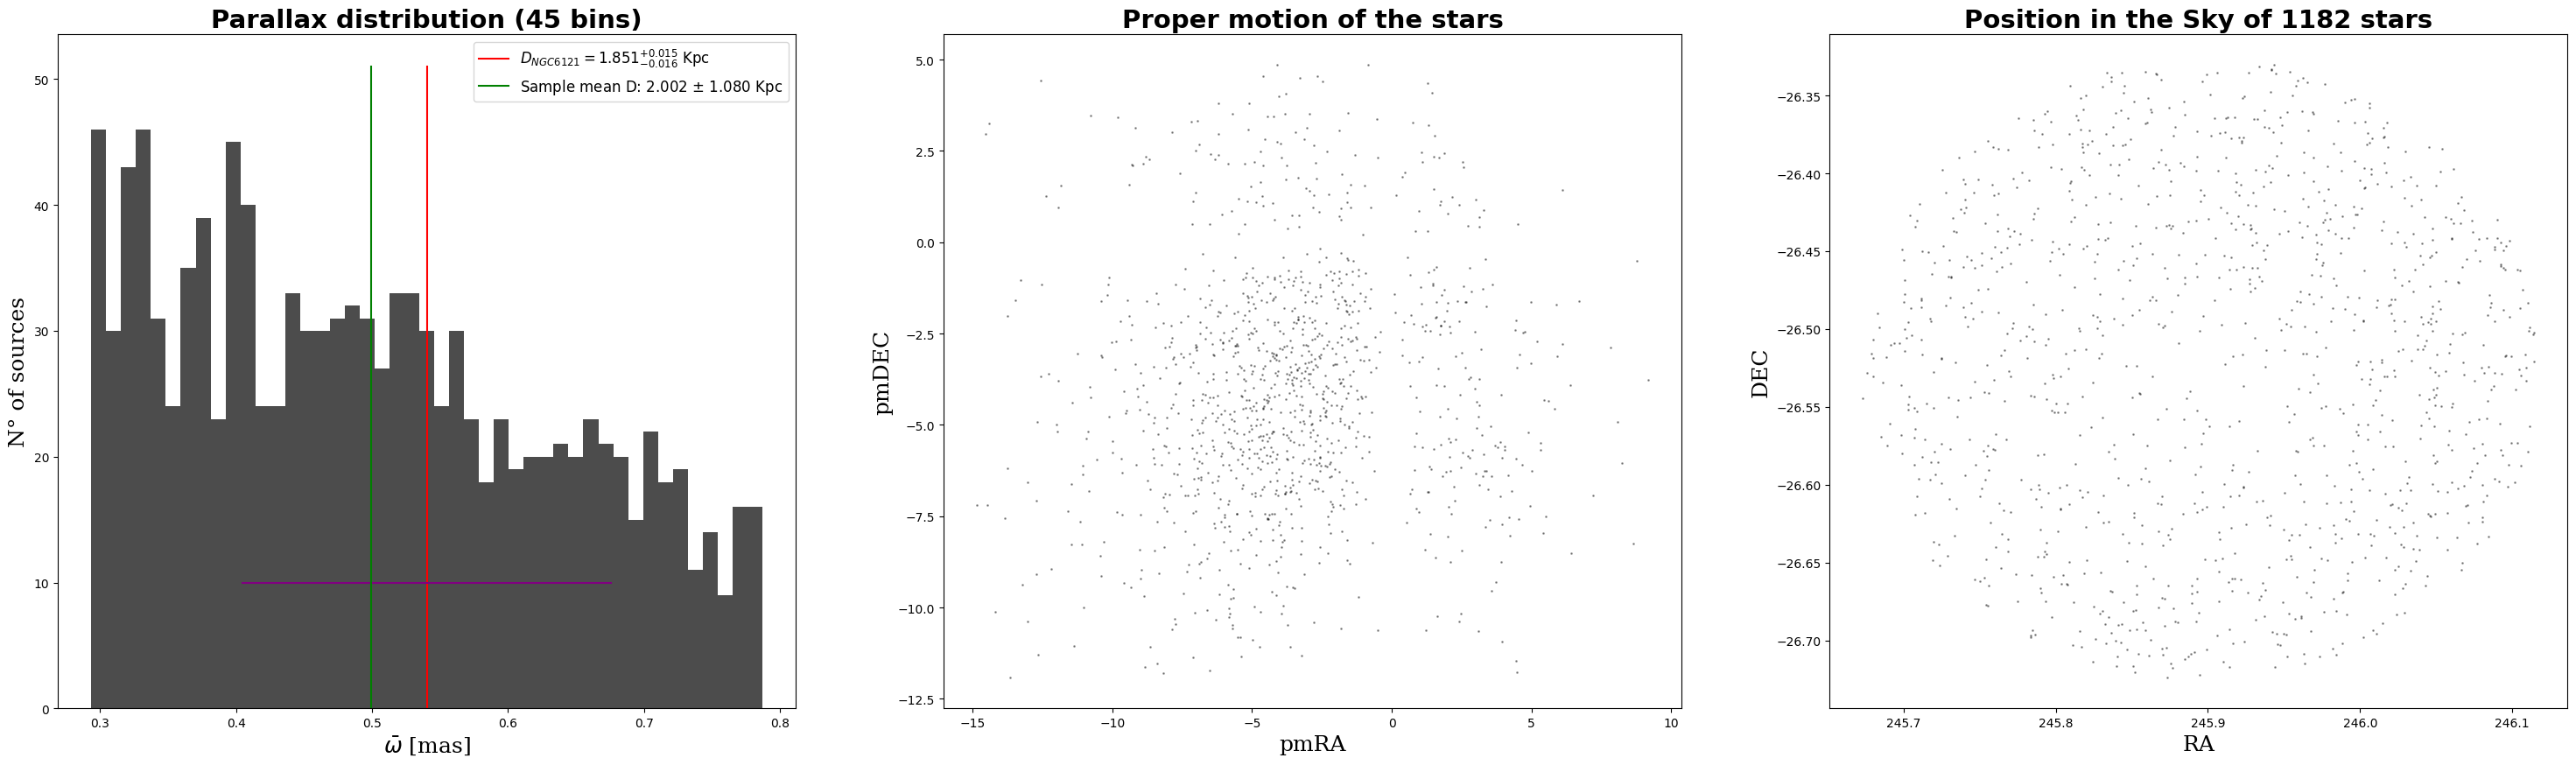

In [ ]:
mean_pxu = np.mean(n6121u_clean[1])
tempu_merr = np.mean(n6121u_clean[2])
n61c_mean_dist_err =  (1/mean_pxu**2) * tempu_merr

fig, (ax0,ax1,ax2) = plt.subplots(ncols=3, nrows=1 ,figsize=(37,10))
c_px4 = ax0.hist(n6121u_clean[1], bins=(int(len(n6121_u)/50)), color='black', alpha=0.7)
ax0.plot([1/1.851, 1/1.851],[0, np.max(c_px4[0]) + 5], c='red', label= r"$D_{NGC 6121}=1.851^{+0.015}_{-0.016}$ Kpc")
ax0.plot([1/1.851 - stdev_n6121_r, 1/1.851 + stdev_n6121_r], [10,10], c='purple')
ax0.plot([mean_pxu, mean_pxu], [0, np.max(c_px4[0]) + 5], c='green', label=r"Sample mean D: {:.3f} $\pm$ {:.3f} Kpc".format(1/mean_pxu, n61c_mean_dist_err))
ax0.legend(loc='best', fontsize='large')
#ax0.set_xlim(0.2, 0.9)
ax0.set_xlabel(r"$\bar{\omega}$ [mas]", fontdict=label_font)
ax0.set_ylabel("N° of sources", fontdict=label_font)
ax0.set_title("Parallax distribution ({:d} bins)".format(int(len(n6121_u)/50)), fontdict=title_font)

ax2.scatter(n6121u_clean[3], n6121u_clean[5], color='black', alpha=0.35, s=1)
ax2.set_title("Position in the Sky of {:d} stars".format(len(n6121u_clean[0])), fontdict=title_font)
ax2.set_xlabel("RA", fontdict=label_font)
ax2.set_ylabel("DEC", fontdict=label_font)
ax1.scatter(n6121u_clean[7], n6121u_clean[9], color='black', alpha=0.35, s=1)
ax1.set_title("Proper motion of the stars", fontdict=title_font)
ax1.set_xlabel("pmRA", fontdict=label_font)
ax1.set_ylabel("pmDEC", fontdict=label_font)

# Photometry parameters

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
 Sample number of objects: 913


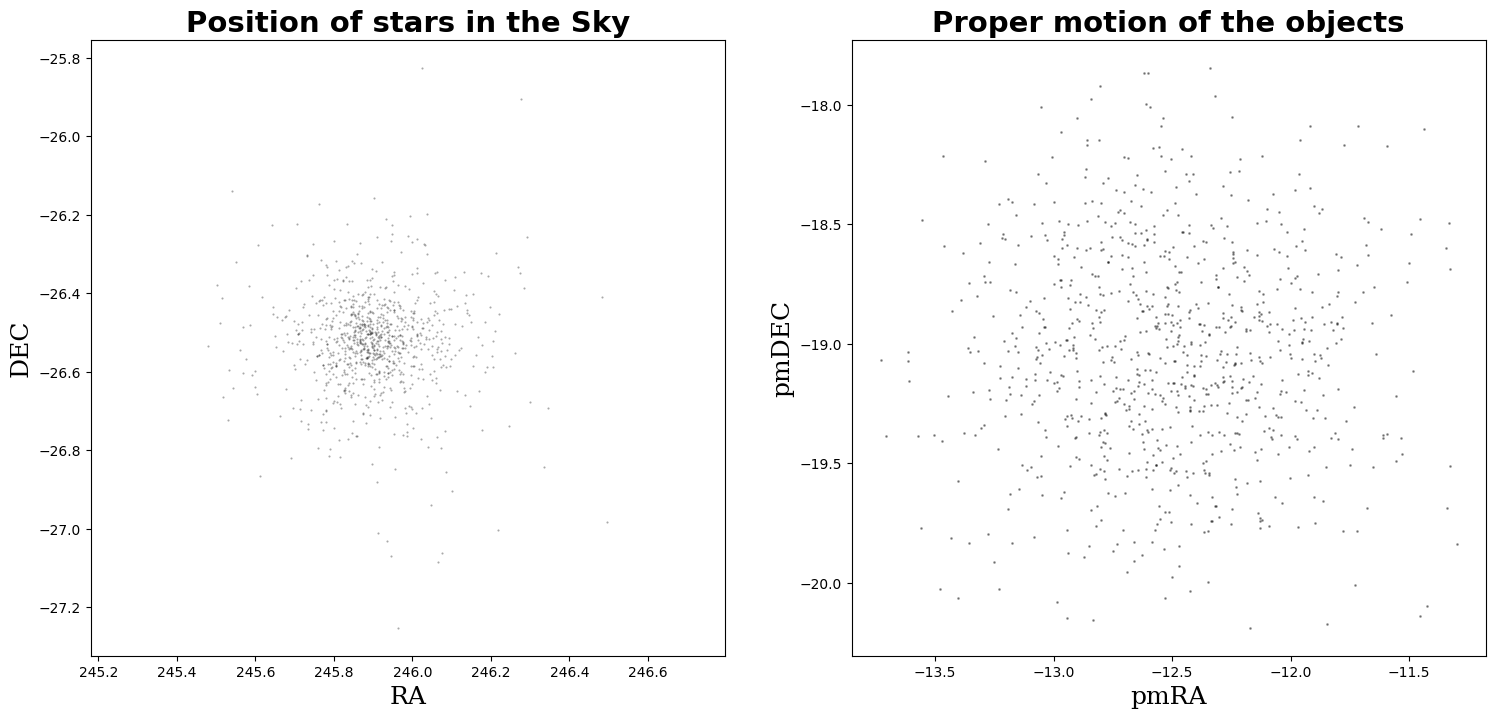

In [3]:
job = Gaia.launch_job_async("SELECT source_id, ra, ra_error, dec_error, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, radial_velocity, radial_velocity_error, \
                              bp_rp, phot_g_mean_mag, phot_bp_rp_excess_factor, teff_gspphot, ra_dec_corr, pmra_pmdec_corr \
                            FROM gaiadr3.gaia_source \
                            WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.8958,-26.5256,0.86))=1 \
                            AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
                            AND ruwe < 1.15 \
                            AND phot_g_mean_mag > 11 \
                            AND astrometric_excess_noise_sig < 2 \
                            AND pmra BETWEEN -13.742720 AND -11.295338 \
                            AND pmdec BETWEEN -20.2148 AND -17.807517")

m3_phot = job.get_results()

print(" Sample number of objects: {:d}".format(len(m3_phot)))

fig, (ax0, ax1) = plt.subplots(ncols=2,nrows=1,figsize=(18,8))
ax0.scatter(m3_phot['ra'], m3_phot['dec'], color='black', alpha=0.35, marker='.', s=1)
ax0.set_title("Position of stars in the Sky", fontdict=title_font)
#ax0.set_ylim(0,4)
ax0.set_xlabel("RA", fontdict=label_font)
ax0.set_ylabel("DEC", fontdict=label_font)
ax1.scatter(m3_phot['pmra'], m3_phot['pmdec'], color='black', alpha=0.35, s=1)
ax1.set_title("Proper motion of the objects", fontdict=title_font)
ax1.set_xlabel("pmRA", fontdict=label_font)
ax1.set_ylabel("pmDEC", fontdict=label_font)
ax0.axis('equal')

p_bin = int(1.5*np.sqrt(len(m3_phot)))
Np = len(m3_phot)

r_c = NGC6121.distance.to(u.kpc).to(u.pc) * np.tan(NGC6121.r_core_deg)          # [pc]
r_t = r_c * 10**(NGC6121.concentration)                                         # [pc]
M_sun = 1.98847e30 * u.kg
G = constants.gravitational_constant * u.m**3/(u.kg*u.s**2)
yr = 3.157e7*u.s
D = NGC6121.distance.to(u.kpc).to(u.km)
D_err = (0.0155*u.kpc).to(u.km)

Text(0.5, 1.0, 'Color-Magnitude Diagram for NGC6121')

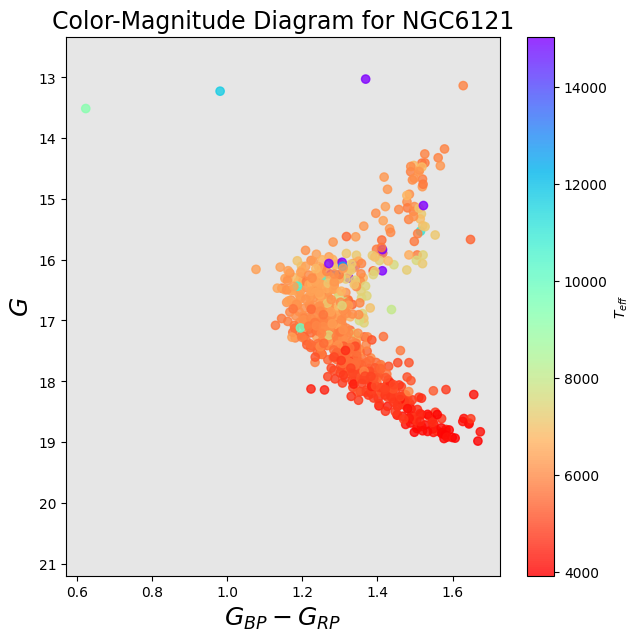

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
ax.set_facecolor((0.9,0.9,0.9))
plt.scatter(m3_phot['bp_rp'], m3_phot['phot_g_mean_mag'], c=m3_phot['teff_gspphot'], alpha=0.8, cmap='rainbow_r')
plt.colorbar(label=r'$T_{eff}$')
plt.ylim(max(m3_phot['phot_g_mean_mag'])+0.51, min(m3_phot['phot_g_mean_mag'])-0.51)
plt.xlabel(r"$G_{BP} - G_{RP}$", fontdict=label_font)
plt.ylabel(r"$G$", fontdict=label_font)
plt.title("Color-Magnitude Diagram for NGC6121", fontsize=17)
#ax.axis('equal')

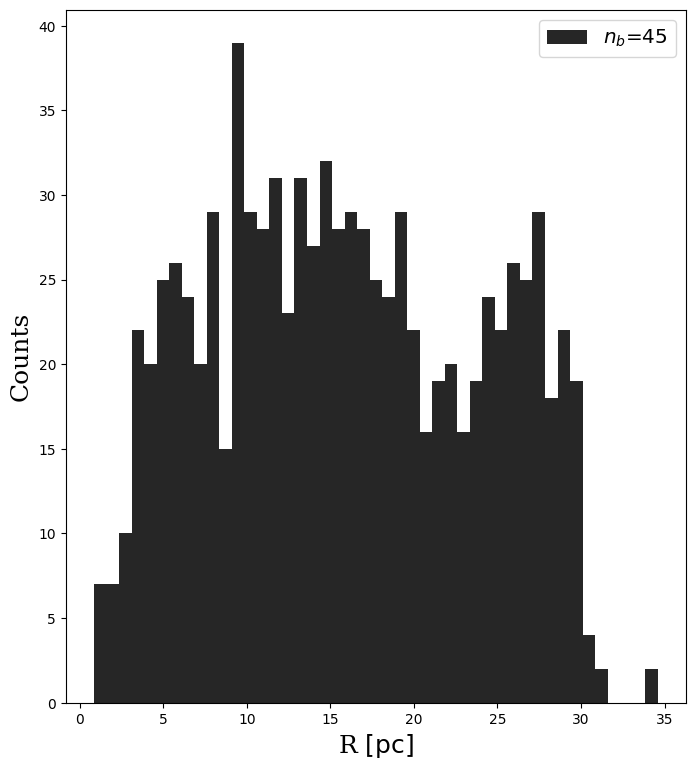

In [5]:
wp = np.zeros(Np)
wp, _ = angular_distance(m3_phot['ra'], m3_phot['dec'], NGC6121.ra.value, NGC6121.dec.value, ra0_err=0, dec0_err=0, corr=0)

Rp = np.zeros(Np)
r2d_p = np.zeros(Np)
dp = np.zeros(Np)

for i in range (0, Np):
  r2d_p[i] = (NGC6121.distance.to(u.kpc).value * np.tan(wp[i]*u.deg))
  dp[i] = (1/m3_phot['parallax'][i]) - NGC6121.distance.to(u.kpc).value
  Rp[i] = np.sqrt((dp[i])**2 + r2d_p[i]**2)

Rp = Rp*u.kpc
r2d_p = r2d_p * u.kpc

fig = plt.figure(figsize=(8,9))
r3dp = plt.hist(Rp.to(u.pc).value, bins=p_bin, color="black", alpha=0.85, label=r"$n_b$={:d}".format(p_bin))
plt.xlabel(r'R $[{\rm pc}]$', fontdict=label_font)
plt.ylabel("Counts", fontdict=label_font)
plt.legend(fontsize='x-large')

pmra_mean  = -12.51 +- 0.24 mas/yr
pmdec_mean = -19.03 +- 0.17 mas/yr


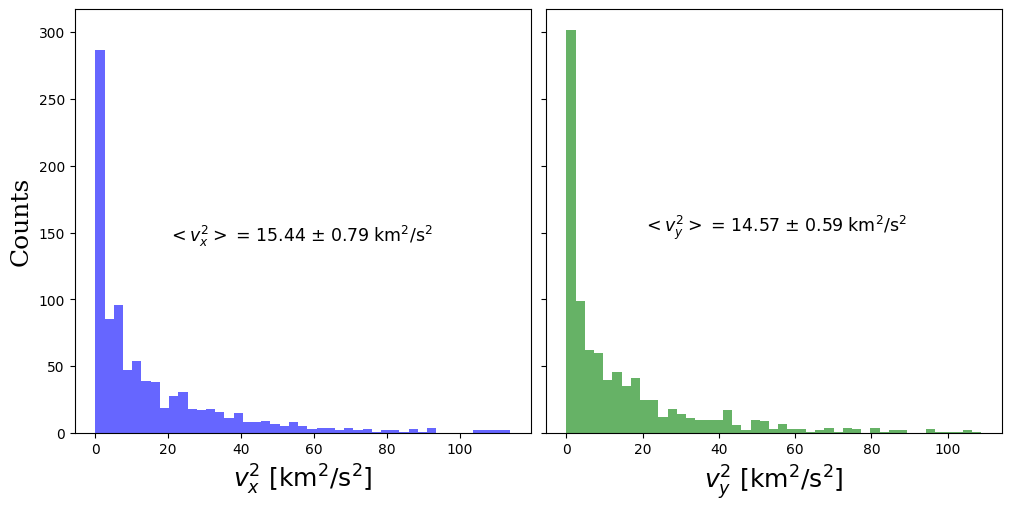

In [6]:
temp_vx        = (m3_phot['pmra'].to(u.rad/u.s) *NGC6121.distance.to(u.kpc).to(u.km)) / u.rad
vx_phot        = temp_vx-np.mean(temp_vx)
temp_vy        = (m3_phot['pmdec'].to(u.rad/u.s) *NGC6121.distance.to(u.kpc).to(u.km)) / u.rad
vy_phot        = temp_vy-np.mean(temp_vy)

vxphot_err = np.sqrt(D**2 * (m3_phot['pmra_error'].to(u.rad/u.s)**2)  + (m3_phot['pmra'].to(u.rad/u.s)**2  * D_err**2))/u.rad
vyphot_err = np.sqrt(D**2 * (m3_phot['pmdec_error'].to(u.rad/u.s)**2)  + (m3_phot['pmdec'].to(u.rad/u.s)**2  * D_err**2))/u.rad

vx2 = (vx_phot)**2
vy2 = (vy_phot)**2

sigma2_vx2 = np.std(vx2)
sigma2_vy2 = np.std(vy2)

vx2_e = 2*vx_phot*vxphot_err
vy2_e = 2*vy_phot*vyphot_err

vx2_avg_err = np.sqrt(sum((i*i) for i in vx2_e))/len(vx2)
vy2_avg_err = np.sqrt(sum((i*i) for i in vy2_e))/len(vy2)

fig, axs = plt.subplots(1,2,figsize=(10,5), layout='constrained', sharey=True)
fig = plt.subplots_adjust(wspace=0)
vx2h = axs[0].hist(vx2, bins=bins_(len(vx_phot)), color='blue', alpha=0.6)
vy2h = axs[1].hist(vy2, bins=bins_(len(vx_phot)), color='green', alpha=0.6)
axs[0].set_xlabel(r'$v_x^2$ $[{\rm km^2/s^{2}}]$', fontdict=label_font)
axs[0].set_ylabel('Counts', fontdict=label_font)
axs[1].set_xlabel(r'$v_y^2$ $[{\rm km^2/s^{2}}]$', fontdict=label_font)
axs[0].text(20 ,vx2h[0].max()/2, r'$<v_x^2>$ = {:.2f} $\pm$ {:.2f} km$^2$/s$^2$'.format(np.mean(vx2).value, vx2_avg_err.value), fontsize=12.5)
axs[1].text(20 ,vy2h[0].max()/2, r'$<v_y^2>$ = {:.2f} $\pm$ {:.2f} km$^2$/s$^2$'.format(np.mean(vy2).value, vy2_avg_err.value), fontsize=12.5)

print('pmra_mean  = {:.2f} +- {:.2f} mas/yr\npmdec_mean = {:.2f} +- {:.2f} mas/yr'.format(np.mean(m3_phot['pmra']), np.sqrt(sum(i*i for i in m3_phot['pmra_error'])/len(m3_phot['pmra'])),
                                                                           np.mean(m3_phot['pmdec']), np.sqrt(sum(i*i for i in m3_phot['pmdec_error'])/len(m3_phot['pmdec']))))

Text(0, 0.5, 'Counts')

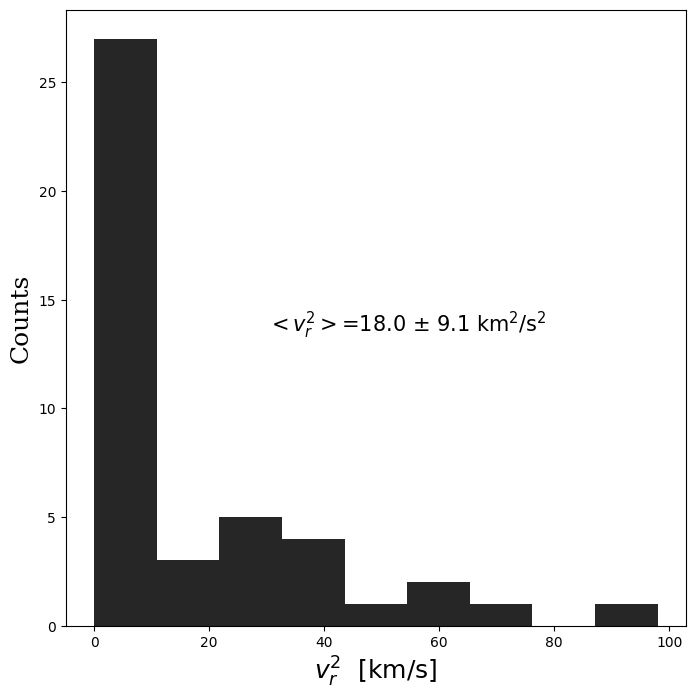

In [7]:
sigma_los3 = np.std(m3_phot['radial_velocity'])
vlos3_max = np.mean(m3_phot['radial_velocity']) + 2.355*sigma_los3
vlos3_min = np.mean(m3_phot['radial_velocity']) - 2.355*sigma_los3

j=0
for x in range (0, len(m3_phot['ra'])):
  if (m3_phot['radial_velocity'][x] < vlos3_max) and (m3_phot['radial_velocity'][x] > vlos3_min):
    j+=1

nv3 = bins_(j)
v_los3 = np.zeros((3, j))        # [0]:Data ; [1]:Data Error ; [2]:Radial Distance

j=0

for x in range (0, len(m3_phot['ra'])):
  if (m3_phot['radial_velocity'][x] < vlos3_max) and (m3_phot['radial_velocity'][x] > vlos3_min):
    v_los3[0][j] = m3_phot['radial_velocity'][x]
    v_los3[1][j] = m3_phot['radial_velocity_error'][x]
    v_los3[2][j] = Rp[x].to(u.kpc).value
    j += 1

v_los_GCRF3 = v_los3[0] - np.mean(v_los3[0])
sigma_vr3 = np.std(v_los_GCRF3)

vlos_3m = np.mean(v_los3[0])
vlos_3e = np.sqrt(sum(i*i for i in v_los3[1]))/len(v_los3[0])
vr2_3e = 2*v_los_GCRF3*v_los3[1]
vr2m_3e = np.sqrt(sum(i*i for i in vr2_3e))/len(v_los3[0])

fig, ax = plt.subplots(1,1,figsize=(8,8))
vh3 = plt.hist(v_los_GCRF3**2, bins=nv3, color='black', alpha=0.85)
ax.text(30, vh3[0].max()/2, r'$<v_r^2>$={:.1f} $\pm$ {:.1f} km$^2$/s$^2$'.format(np.mean(v_los_GCRF3**2), vr2m_3e), fontsize=15)
plt.xlabel(r'$v_r^2$  $[{\rm km/s}]$', fontdict=label_font)
plt.ylabel('Counts', fontdict=label_font)

Calculated from data:
<V^2> = 45.01 +- 2.96 km2 / s2
Calculated from previous calculus:
<V^2> = 48.02 +- 1.06 km2 / s2

Scarto dello 6.265 %


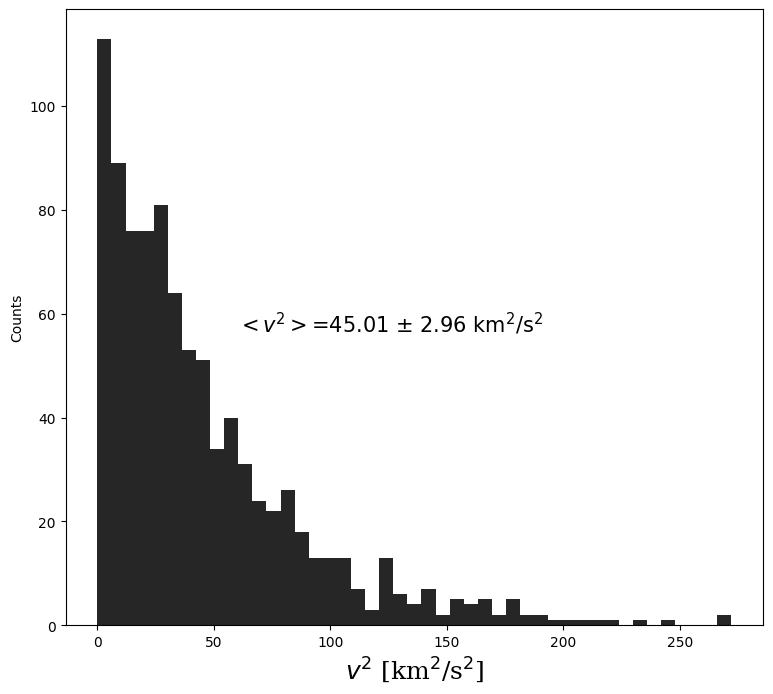

In [8]:
print('s(x)={:.3f} ; s(y)={:.3f} ; s(r)={:.3f} km/s'.format(sigma2_vx2, sigma2_vy2, sigma_vr3))
sigmaCP = (np.sqrt(sigma2_vx2.value + sigma2_vy2.value + sigma_vr3**2))*(1+(wp.max()/0.86)**2)**0.25
print('\nS(0) = {:.3f} km/s'.format(sigmaCP))

# Total squared velocity (on isotropy assumption)
V2p = 3*(vx2 + vy2)/2
V2p_e = 3*np.sqrt( vx2_e**2 +  vy2_e**2 )

V2p_m = np.average(V2p)
V2pm_e = np.sqrt(sum(i*i for i in V2p_e))/len(V2p)

fig, ax = plt.subplots(figsize=(9,8))
v2h = plt.hist(V2p, bins=bins_(len(vx_phot)), color='black', alpha=0.85)
ax.text(60, v2h[0].max()/2, r'$<v^2>$={:.2f} $\pm$ {:.2f} km$^2$/s$^2$'.format(V2p_m.value, V2pm_e.value), fontsize=15)
plt.ylabel('Counts')
plt.xlabel(r'$v^2$ [km$^2$/s$^2$]', fontdict=label_font)
output.clear()

print('Calculated from data:\n<V^2> = {:.2f} +- {:.2f}'.format(V2p_m.value, V2pm_e))
print('Calculated from previous calculus:\n<V^2> = {:.2f} +- {:.2f} km2 / s2'.format((np.mean(vx_phot**2).value+np.mean(vy_phot**2).value+np.mean(v_los_GCRF3**2)),
                                                                            np.sqrt(vx2_avg_err.value**2 + vy2_avg_err.value**2 + vr2m_3e)/3))
print('\nScarto dello {:.3f} %'.format((1-V2p_m.value/(np.mean(vx_phot**2).value+np.mean(vy_phot**2).value+np.mean(v_los_GCRF3**2)))*100))

# Astrometry parameters


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]

Sample number of objects: 920, 91 with Radial_Velocity


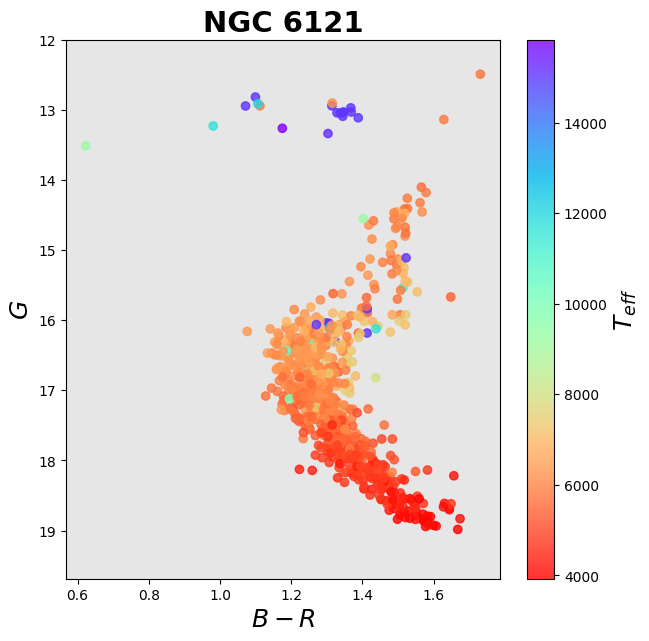

In [9]:
job3 = Gaia.launch_job_async("SELECT source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, \
                              radial_velocity, radial_velocity_error, bp_rp, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, teff_gspphot, ra_dec_corr, pmra_pmdec_corr \
                            FROM gaiadr3.gaia_source \
                            WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.897,-26.526,0.86))=1 \
                            AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
                            AND abs(parallax_error/parallax)<0.50\
                            AND abs(pmra_error/pmra)<0.30 \
                            AND abs(pmdec_error/pmdec)<0.30 \
                            AND pmra IS NOT NULL AND abs(pmra)>0 \
                            AND pmdec IS NOT NULL AND abs(pmdec)>0 \
                            AND pmra BETWEEN -13.742720 AND -11.295338 \
                            AND pmdec BETWEEN -20.214805 AND -17.807517")

# AND parallax IS NOT NULL AND parallax>0.403256 AND parallax<0.677349 -- AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
n6121c = job3.get_results()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
ax.set_facecolor((0.9,0.9,0.9))
plt.scatter(n6121c['bp_rp'], n6121c['phot_g_mean_mag'], c=n6121c['teff_gspphot'], alpha=0.8, cmap='rainbow_r')
plt.colorbar().set_label(label=r'$T_{eff}$',size=18)
plt.ylim(max(n6121c['phot_g_mean_mag'])+0.51, 12)#min(n6121c['phot_g_mean_mag']))
plt.xlabel(r"$B - R$", fontdict=label_font)
plt.ylabel(r"$G$", fontdict=label_font)
plt.title("NGC 6121", fontdict=title_font)

n_bin = int(1.5*np.sqrt(len(n6121c)))
N = len(n6121c)
N_v = 0
for i in range (0, len(n6121c)):
  if n6121c['radial_velocity'][i] != '--':
    N_v += 1

print("\nSample number of objects: {:d}, {:d} with Radial_Velocity".format(N, N_v))

<D> = 1.85 +- 0.38 kpc
<w> = 0.5402 +- 0.0014 mas


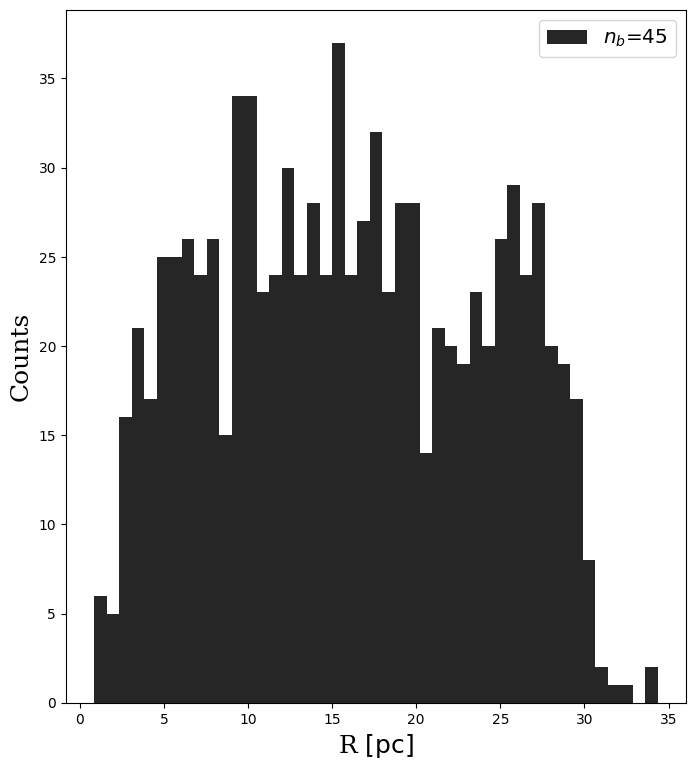

In [10]:
r_x = 1/n6121c['parallax']
rx_m = np.mean(r_x)

srx = np.std(r_x)

rx_e = np.sqrt(1/(n6121c['parallax'])**4 * n6121c['parallax_error']**2)
rxm_e = np.sqrt(sum((i*i) for i in rx_e))/np.sqrt(N)

print('<D> = {:.2f} +- {:.2f} kpc'.format(rx_m, rxm_e))
print('<w> = {:.4f} +- {:.4f} mas'.format(np.mean(n6121c['parallax']), np.sqrt(np.sum(n6121c['parallax_error']**-2)**-1)))
# Calcolo della distanza radiale con w2

R = np.zeros(len(n6121c))
r2d = np.zeros(len(n6121c))
d = np.zeros(len(n6121c))
r_x = np.zeros(len(n6121c))

w1, _= angular_distance(n6121c['ra'], n6121c['dec'], NGC6121.ra, NGC6121.dec, ra0_err=0, dec0_err=0, corr=0)

for i in range (0, len(n6121c)):
  r_x[i] = 1/n6121c["parallax"][i]
  r2d[i] = (NGC6121.distance.to(u.kpc).value * np.tan(w1[i]*u.deg))             # projected 2d distance [kpc]
  d[i] = r_x[i] - NGC6121.distance.to(u.kpc).value                              # line-of-sight position in the GC [kpc]
  R[i] = np.sqrt((d[i])**2 + r2d[i]**2)                                         # Real modulus distance from GC centre [kpc or pc]

R = R*u.kpc
r2d = r2d * u.kpc

fig = plt.figure(figsize=(8,9))
r3dh = plt.hist(R.to(u.pc).value, bins=n_bin, color="black", alpha=0.85, label=r"$n_b$={:d}".format(n_bin))
plt.xlabel(r'R $[{\rm pc}]$', fontdict=label_font)
plt.ylabel("Counts", fontdict=label_font)
plt.legend(fontsize='x-large')

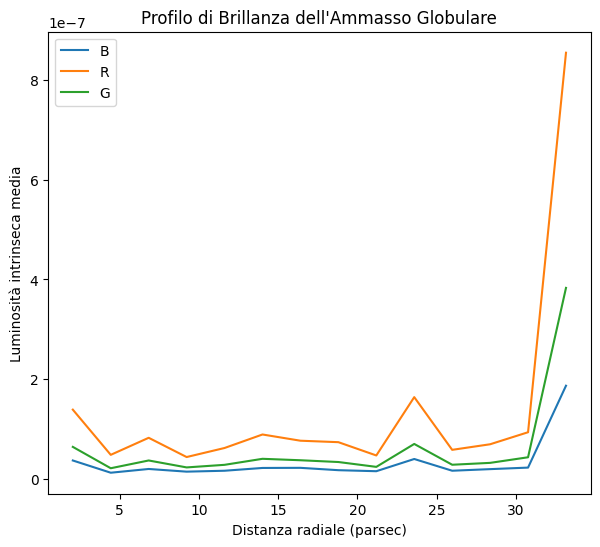

In [11]:
# Dati fotometrici (magnitudini medie nei filtri B, R, G)
magnitudine_B = n6121c['phot_bp_mean_mag']  # Sostituisci con i tuoi dati
magnitudine_R = n6121c['phot_rp_mean_mag']  # Sostituisci con i tuoi dati
magnitudine_G = n6121c['phot_g_mean_mag']  # Sostituisci con i tuoi dati

# Distanze calcolate utilizzando la relazione parallasse-distanza
distanze_parsec = 1/n6121c['parallax']
dist_radiale = R.to(u.pc).value

# Correzione delle magnitudini per ottenere magnitudini assolute
magnitudine_assoluta_B = magnitudine_B - 5 * np.log10(distanze_parsec) + 5
magnitudine_assoluta_R = magnitudine_R - 5 * np.log10(distanze_parsec) + 5
magnitudine_assoluta_G = magnitudine_G - 5 * np.log10(distanze_parsec) + 5

# Definizione di bin radiali concentrici
bordi_bin = np.linspace(min(dist_radiale), max(dist_radiale), num=15)
bin_centri = 0.5 * (bordi_bin[:-1] + bordi_bin[1:])

# Calcolo della luminosità intrinseca per ciascun bin
luminosita_media_B = [np.mean(10 ** (-0.4 * magnitudine_assoluta_B[(dist_radiale >= bordi_bin[i]) & (dist_radiale < bordi_bin[i + 1])])) for i in range(len(bordi_bin) - 1)]
luminosita_media_R = [np.mean(10 ** (-0.4 * magnitudine_assoluta_R[(dist_radiale >= bordi_bin[i]) & (dist_radiale < bordi_bin[i + 1])])) for i in range(len(bordi_bin) - 1)]
luminosita_media_G = [np.mean(10 ** (-0.4 * magnitudine_assoluta_G[(dist_radiale >= bordi_bin[i]) & (dist_radiale < bordi_bin[i + 1])])) for i in range(len(bordi_bin) - 1)]

# Grafico del profilo di brillanza
plt.figure(figsize=(7, 6))
plt.plot(bin_centri, luminosita_media_B, label='B')
plt.plot(bin_centri, luminosita_media_R, label='R')
plt.plot(bin_centri, luminosita_media_G, label='G')
plt.xlabel('Distanza radiale (parsec)')
plt.ylabel('Luminosità intrinseca media')
plt.title('Profilo di Brillanza dell\'Ammasso Globulare')
plt.legend()
plt.show()


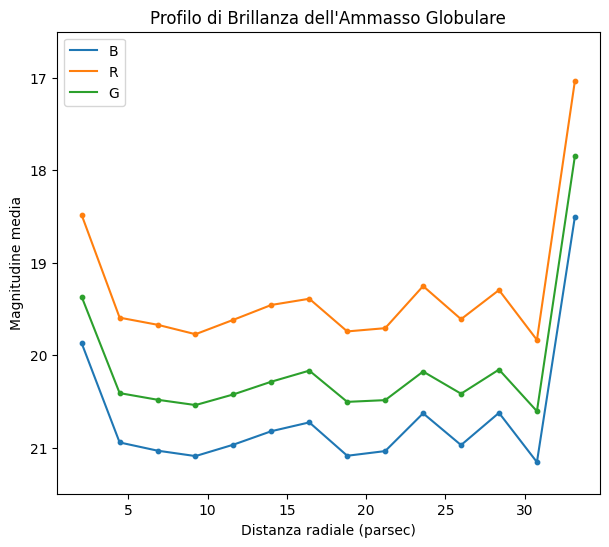

In [12]:
G_order = [np.mean(magnitudine_assoluta_G[(dist_radiale >= bordi_bin[i]) & (dist_radiale < bordi_bin[i + 1])]) for i in range(len(bordi_bin) - 1)]
R_order = [np.mean(magnitudine_assoluta_R[(dist_radiale >= bordi_bin[i]) & (dist_radiale < bordi_bin[i + 1])]) for i in range(len(bordi_bin) - 1)]
B_order = [np.mean(magnitudine_assoluta_B[(dist_radiale >= bordi_bin[i]) & (dist_radiale < bordi_bin[i + 1])]) for i in range(len(bordi_bin) - 1)]

plt.figure(figsize=(7, 6))
plt.plot(bin_centri, B_order, label='B')
plt.plot(bin_centri, R_order, label='R')
plt.plot(bin_centri, G_order, label='G')
plt.scatter(bin_centri, B_order, s=10)
plt.scatter(bin_centri, R_order, s=10)
plt.scatter(bin_centri, G_order, s=10)
plt.xlabel('Distanza radiale (parsec)')
plt.ylabel('Magnitudine media')
plt.title('Profilo di Brillanza dell\'Ammasso Globulare')
plt.ylim(21.5,16.5)
plt.legend()
plt.show()

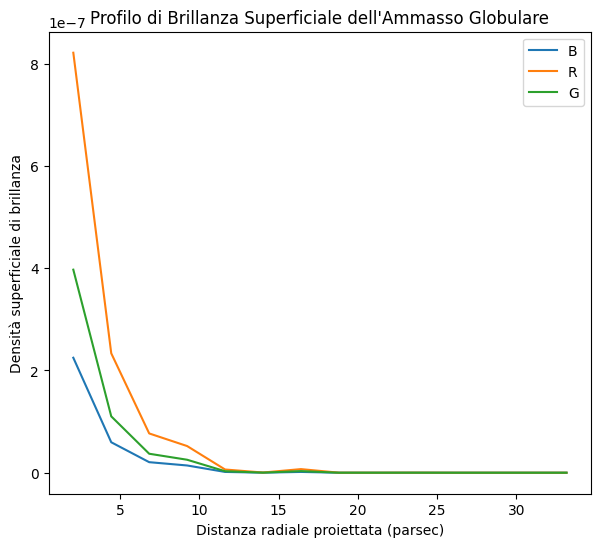

In [13]:
distanze_proiettate = r2d.to(u.pc).value

bordi_bin2 = np.linspace(min(distanze_proiettate), max(distanze_proiettate), num=10)
bin_centri2 = 0.5 * (bordi_bin2[:-1] + bordi_bin2[1:])

densita_superficiale_B = [np.sum(10 ** (-0.4 * magnitudine_assoluta_B[(distanze_proiettate >= bordi_bin[i]) & (distanze_proiettate < bordi_bin[i + 1])])) / np.pi / (bordi_bin[i + 1]**2 - bordi_bin[i]**2) for i in range(len(bordi_bin) - 1)]
densita_superficiale_R = [np.sum(10 ** (-0.4 * magnitudine_assoluta_R[(distanze_proiettate >= bordi_bin[i]) & (distanze_proiettate < bordi_bin[i + 1])])) / np.pi / (bordi_bin[i + 1]**2 - bordi_bin[i]**2) for i in range(len(bordi_bin) - 1)]
densita_superficiale_G = [np.sum(10 ** (-0.4 * magnitudine_assoluta_G[(distanze_proiettate >= bordi_bin[i]) & (distanze_proiettate < bordi_bin[i + 1])])) / np.pi / (bordi_bin[i + 1]**2 - bordi_bin[i]**2) for i in range(len(bordi_bin) - 1)]

plt.figure(figsize=(7, 6))
plt.plot(bin_centri, densita_superficiale_B, label='B')
plt.plot(bin_centri, densita_superficiale_R, label='R')
plt.plot(bin_centri, densita_superficiale_G, label='G')
plt.xlabel('Distanza radiale proiettata (parsec)')
plt.ylabel('Densità superficiale di brillanza')
plt.title('Profilo di Brillanza Superficiale dell\'Ammasso Globulare')
plt.legend()
plt.show()

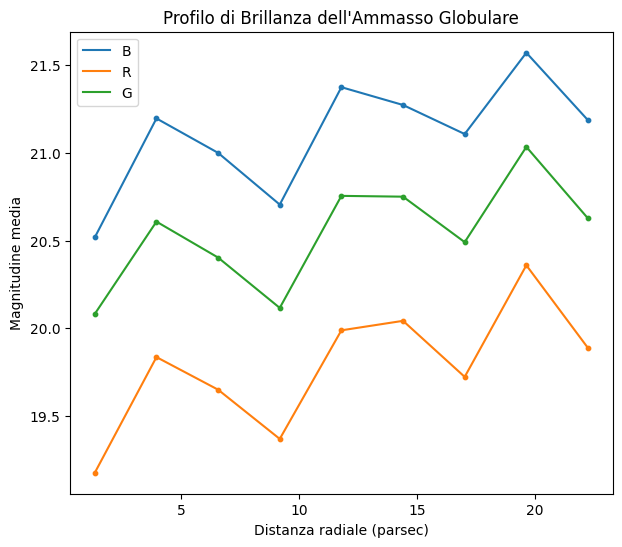

In [14]:
G_rad = [np.mean(magnitudine_assoluta_G[(distanze_proiettate >= bordi_bin2[i]) & (distanze_proiettate < bordi_bin2[i + 1])]) for i in range(len(bordi_bin2) - 1)]
R_rad = [np.mean(magnitudine_assoluta_R[(distanze_proiettate >= bordi_bin2[i]) & (distanze_proiettate < bordi_bin2[i + 1])]) for i in range(len(bordi_bin2) - 1)]
B_rad = [np.mean(magnitudine_assoluta_B[(distanze_proiettate >= bordi_bin2[i]) & (distanze_proiettate < bordi_bin2[i + 1])]) for i in range(len(bordi_bin2) - 1)]

plt.figure(figsize=(7, 6))
plt.plot(bin_centri2, B_rad, label='B')
plt.plot(bin_centri2, R_rad, label='R')
plt.plot(bin_centri2, G_rad, label='G')
plt.scatter(bin_centri2, B_rad, s=10)
plt.scatter(bin_centri2, R_rad, s=10)
plt.scatter(bin_centri2, G_rad, s=10)
plt.xlabel('Distanza radiale (parsec)')
plt.ylabel('Magnitudine media')
plt.title('Profilo di Brillanza dell\'Ammasso Globulare')
#plt.ylim(21.5,16.5)
plt.legend()
plt.show()

pmra_mean  = -12.52 +- 0.15 mas/yr
pmdec_mean = -19.03 +- 0.10 mas/yr


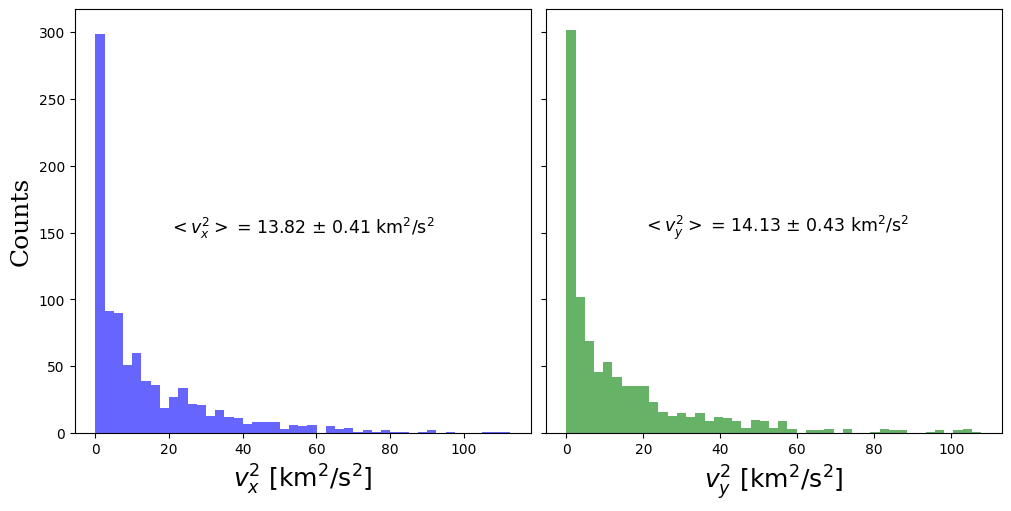

In [15]:
pmra_mean = np.mean(n6121c['pmra']) * (u.mas/u.yr)
pmdec_mean = np.mean(n6121c['pmdec']) * (u.mas/u.yr)
pmra_max = np.max(n6121c['pmra'])
pmdec_max = np.max(n6121c['pmdec'])

vx_km = n6121c['pmra'].to(u.mas/u.yr).to(u.rad/u.s) *NGC6121.distance.to(u.kpc).to(u.km) / u.rad
vy_km = n6121c['pmdec'].to(u.mas/u.yr).to(u.rad/u.s)*NGC6121.distance.to(u.kpc).to(u.km) / u.rad

vx_mean = np.mean(vx_km)
vy_mean = np.mean(vy_km)

vx = vx_km - vx_mean
vy = vy_km - vy_mean
v_u = np.sqrt( vx**2 + vy**2 )

sigma_vx = np.std(vx)
sigma_vy = np.std(vy)
sigma2d = np.std(v_u)

#errors
vxkm_e = np.sqrt(D**2 * n6121c['pmra_error'].to(u.rad/u.s)**2  + n6121c['pmra'].to(u.rad/u.s)**2  * D_err**2)/u.rad
vykm_e = np.sqrt(D**2 * n6121c['pmdec_error'].to(u.rad/u.s)**2 + n6121c['pmdec'].to(u.rad/u.s)**2 * D_err**2)/u.rad

vxm_e = np.sqrt(sum((i*i) for i in vxkm_e))/N
vym_e = np.sqrt(sum((i*i) for i in vykm_e))/N

vx_e = np.sqrt(vxm_e**2 + vxkm_e**2)
vy_e = np.sqrt(vym_e**2 + vykm_e**2)

vx2 = vx**2
vy2 = vy**2

sigma_vx2 = np.std(vx**2)
sigma_vy2 = np.std(vy**2)

vx2_e = 2*vx*vx_e
vy2_e = 2*vy*vy_e

vx2_avg_err = np.sqrt(sum((i*i) for i in vx2_e))/len(vx2)
vy2_avg_err = np.sqrt(sum((i*i) for i in vy2_e))/len(vy2)

fig, axs = plt.subplots(1,2,figsize=(10,5), layout='constrained', sharey=True)
fig = plt.subplots_adjust(wspace=0)
vx2h = axs[0].hist(vx**2, bins=n_bin, color='blue', alpha=0.6)
vy2h = axs[1].hist(vy**2, bins=n_bin, color='green', alpha=0.6)
axs[0].set_xlabel(r'$v_x^2$ $[{\rm km^2/s^{2}}]$', fontdict=label_font)
axs[0].set_ylabel('Counts', fontdict=label_font)
axs[1].set_xlabel(r'$v_y^2$ $[{\rm km^2/s^{2}}]$', fontdict=label_font)
axs[0].text(20 ,vx2h[0].max()/2, r'$<v_x^2>$ = {:.2f} $\pm$ {:.2f} km$^2$/s$^2$'.format(np.mean(vx**2).value, vx2_avg_err.value), fontsize=12.5)
axs[1].text(20 ,vy2h[0].max()/2, r'$<v_y^2>$ = {:.2f} $\pm$ {:.2f} km$^2$/s$^2$'.format(np.mean(vy**2).value, vy2_avg_err.value), fontsize=12.5)

print('pmra_mean  = {:.2f} +- {:.2f} mas/yr\npmdec_mean = {:.2f} +- {:.2f} mas/yr'.format(pmra_mean.value, np.sqrt(sum(i*i for i in n6121c['pmra_error'])/len(n6121c['pmra'])),
                                                                           pmdec_mean.value, np.sqrt(sum(i*i for i in n6121c['pmdec_error'])/len(n6121c['pmdec']))))

<vx>=-4.08e-15 km / s ; <vy>=3.12e-15 km / s


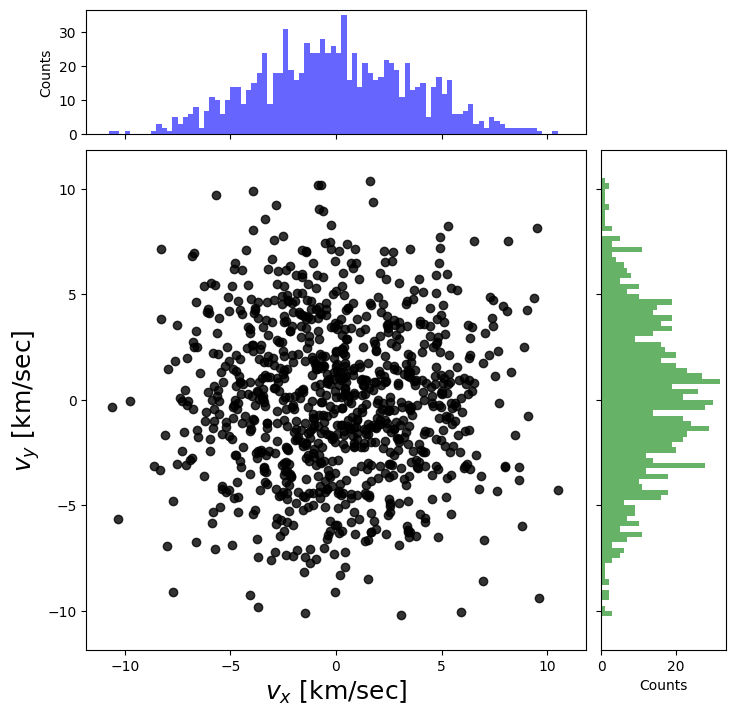

In [16]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, color='black', alpha=0.8)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, color='blue', alpha=0.6)
    ax_histy.hist(y, bins=bins, orientation='horizontal', color='green', alpha=0.6)

fig = plt.figure(figsize=(8,8))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(vx.to(u.km/u.s).value, vy.to(u.km/u.s).value, ax, ax_histx, ax_histy)
ax_histx.set_ylabel('Counts')
ax_histy.set_xlabel('Counts')
ax.set_xlabel(r'$v_x$ $[{\rm km/sec}]$', fontdict=label_font)
ax.set_ylabel(r'$v_y$ $[{\rm km/sec}]$', fontdict=label_font)

print('<vx>={:.2e} ; <vy>={:.2e}'.format(np.mean(vx), np.mean(vy)))

**Velocità line-of-sight $v_{los}$**

Text(0, 0.5, 'Counts')

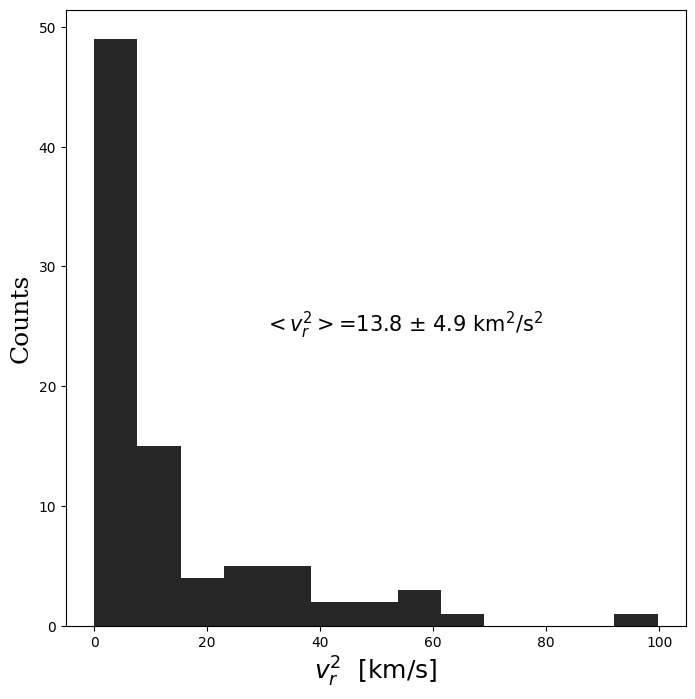

In [17]:
sigma_los = np.std(n6121c['radial_velocity'])
vlos_max = np.mean(n6121c['radial_velocity']) + 2.355*sigma_los
vlos_min = np.mean(n6121c['radial_velocity']) - 2.355*sigma_los

j=0
for x in range (0, N):
  if (n6121c['radial_velocity'][x] < vlos_max) and (n6121c['radial_velocity'][x] > vlos_min):
    j+=1

nv2 = int(1.5*np.sqrt(j))
v_los = np.zeros((3, j))        # [0]:Data ; [1]:Data Error ; [2]:Radial Distance

j=0

for x in range (0, N):
  if (n6121c['radial_velocity'][x] < vlos_max) and (n6121c['radial_velocity'][x] > vlos_min):
    v_los[0][j] = n6121c['radial_velocity'][x]
    v_los[1][j] = n6121c['radial_velocity_error'][x]
    v_los[2][j] = R[x].to(u.kpc).value
    j += 1

v_los_GCRF = v_los[0] - np.mean(v_los[0])
sigma_vr = np.std(v_los_GCRF)

vlos_m = np.mean(v_los[0])
vlos_e = np.sqrt(sum(i*i for i in v_los[1]))/len(v_los[0])
vr2_e = 2*v_los_GCRF*v_los[1]
vr2m_e = np.sqrt(sum(i*i for i in vr2_e))/len(v_los[0])

fig, ax = plt.subplots(1,1,figsize=(8,8))
vh2 = plt.hist(v_los_GCRF**2, bins=nv2, color='black', alpha=0.85)
ax.text(30, vh2[0].max()/2, r'$<v_r^2>$={:.1f} $\pm$ {:.1f} km$^2$/s$^2$'.format(np.mean(v_los_GCRF**2), vr2m_e), fontsize=15)
plt.xlabel(r'$v_r^2$  $[{\rm km/s}]$', fontdict=label_font)
plt.ylabel('Counts', fontdict=label_font)

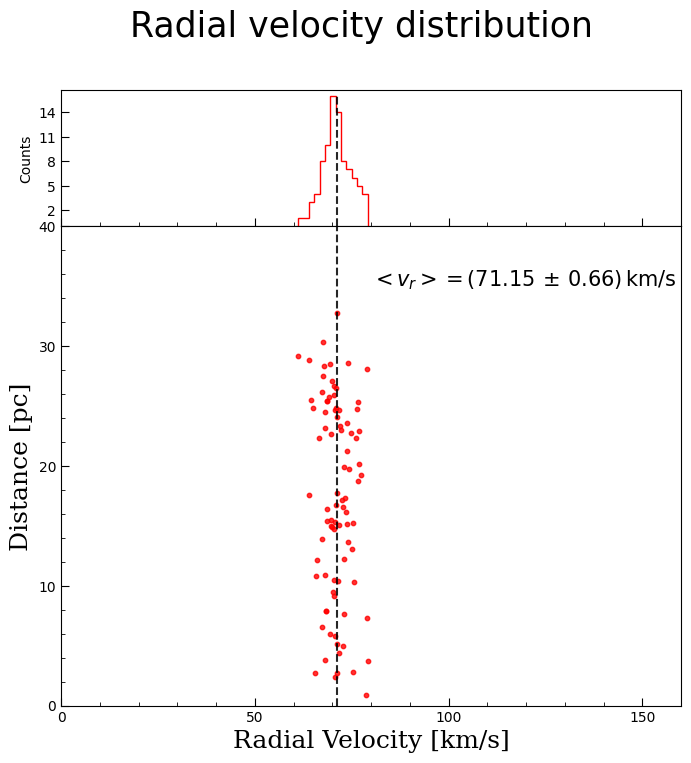

In [18]:
from matplotlib.textpath import FontProperties

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, height_ratios=[1,3.5], figsize=(8,8), sharex=True)
fig.subplots_adjust(hspace=0)

ax1.scatter(v_los[0], v_los[2]*1000, c='red', alpha=0.8, s=10)
#ax0.errorbar(R, v_los, yerr=v_los_err, fmt=' ', color='black', linewidth=1.5)
ax1.set_xticks(np.arange(-300, 300, 100))
ax1.set_yticks(np.arange(-10, 100, 10))
ax1.set_xlim(0,160)#-210,280)
ax1.set_ylim(0, 40)

#Media scritta
ax1.text(80, 35, r'$<v_r>=(${:.2f}$\,\pm\,${:.2f}$)\,$km/s'.format(vlos_m, vlos_e), color='black', fontsize=15)

vh = ax0.hist(v_los[0], bins=nv2, color='red', histtype='step', orientation='vertical')
ax0.set_xticks(np.arange(-300, 300, 50))
ax0.set_yticks(np.arange(2, 20, 3))
ax0.set_xlim(0,160)#-210, 280)

#linea
ax1.plot( [v_los[0].mean(), v_los[0].mean()], [0, 50], linestyle='--', c='black', alpha=0.85)
ax0.plot( [v_los[0].mean(), v_los[0].mean()], [0, vh[0].max()],  linestyle='--', c='black', alpha=0.85)

#labels
ax1.set_ylabel('Distance [pc]', fontdict=label_font)
ax1.set_xlabel(r'Radial Velocity [km/s]', fontdict=label_font)
ax0.set_ylabel('Counts')

#minor ticks
ax0.minorticks_on()
ax1.minorticks_on()

ax0.tick_params(axis="both",direction="in", size=6)
ax0.tick_params(axis='y', which="minor",direction="in", size=0)
ax0.tick_params(axis='x', which="minor",direction="in", size=3)
ax1.tick_params(axis="both",direction="in", size=6)
ax1.tick_params(which="minor",direction="in", size=3)

fig = plt.suptitle('Radial velocity distribution', fontsize=25)

plt.show()

Total 3D velocity on isotropy assumption

Calculated from data:
<V^2> = 41.92 +- 0.89 km2 / s2
Calculated from previous calculus:
<V^2> = 41.70 +- 0.76 km2 / s2

Scarto dello -0.534 %


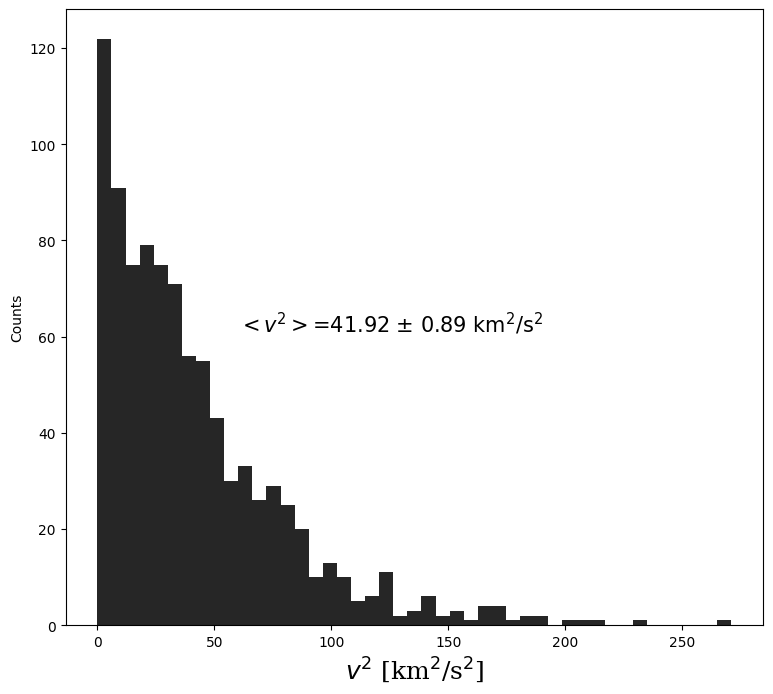

In [19]:
print('s(x)={:.3f} ; s(y)={:.3f} ; s(r)={:.3f} km/s'.format(sigma_vx, sigma_vy, sigma_vr))
sigmaC = (np.sqrt(sigma_vx.value**2 + sigma_vy.value**2 + sigma_vr**2))*(1+(w1.max()/0.86)**2)**0.25
print('\nS(0) = {:.3f} km/s'.format(sigmaC))

# Total squared velocity (on isotropy assumption)
V2 = 3*(vx2 + vy2)/2
V2_e = 3*np.sqrt( vx2 * vx_e**2 + vy2 * vy_e**2 )

V2_m = np.average(V2)
V2m_e = np.sqrt(sum(i*i for i in V2_e))/len(V2)

fig, ax = plt.subplots(figsize=(9,8))
v2h = plt.hist(V2, bins=n_bin, color='black', alpha=0.85)
ax.text(60, v2h[0].max()/2, r'$<v^2>$={:.2f} $\pm$ {:.2f} km$^2$/s$^2$'.format(V2_m.value, V2m_e.value), fontsize=15)
plt.ylabel('Counts')
plt.xlabel(r'$v^2$ [km$^2$/s$^2$]', fontdict=label_font)
output.clear()

print('Calculated from data:\n<V^2> = {:.2f} +- {:.2f}'.format(V2_m.value, V2m_e))
print('Calculated from previous calculus:\n<V^2> = {:.2f} +- {:.2f} km2 / s2'.format((np.mean(vx**2).value+np.mean(vy**2).value+np.mean(v_los_GCRF**2)),
                                                                            np.sqrt(vx2_avg_err.value**2 + vy2_avg_err.value**2 + vr2m_e)/3))
print('\nScarto dello {:.3f} %'.format((1-V2_m.value/(np.mean(vx**2).value+np.mean(vy**2).value+np.mean(v_los_GCRF**2)))*100))

**FIle output delle velocità**

In [20]:
dat3 = {'Vx': vx, 'Vx_err': vx_e,
      'Vy': vy, 'Vy_err': vy_e,
      'V2x': vx2, 'V2x_err': vx2_e,
      'V2y': vy2, 'V2y_err': vy2_e,
      'V2_tot': V2, 'V2_err': V2_e}

c3 = pd.DataFrame(data=dat3)
c3.to_csv("/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Velocities_{:d}.txt".format(N), sep="\t")

# Densities


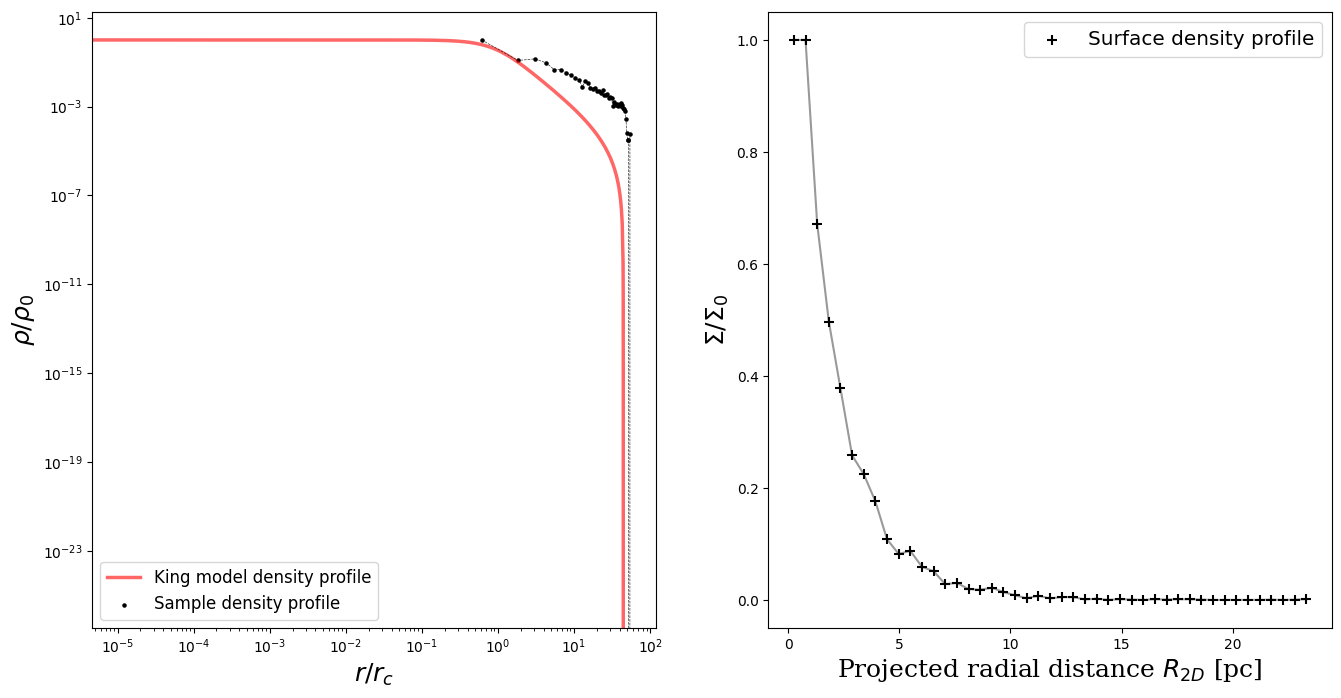

In [21]:
r_km, n_km = np.loadtxt('/content/gdrive/MyDrive/Tesi_di_laurea/Data/w0_7_4.txt', unpack=True, usecols=(0,3), skiprows=1)

r2dh = np.histogram(r2d.to(u.pc), bins=n_bin)
r3dh = np.histogram(R.to(u.pc), bins=n_bin)

V = np.zeros(n_bin)
rr1 = np.zeros(n_bin+1)
rr2 = np.zeros(n_bin+1)

bw = (R.to(u.pc).value).max()/n_bin               # [pc]

rr1[0] = 0.
rr2[0] = bw

for x in range (0, n_bin):
  V[x] = (4/3)*np.pi*(rr2[x]**3 - rr1[x]**3)      # [pc^3]

  rr1[x+1] = rr1[x] + bw
  rr2[x+1] = rr2[x] + bw

rho3D = (M_sun.to(u.Msun))*r3dh[0]/(V*u.pc**3)                     #[kg/pc^3]

S = np.zeros(n_bin)
r1 = np.zeros(n_bin+1)
r2 = np.zeros(n_bin+1)

bw = (r2d.to(u.pc).value).max()/n_bin # [pc]

r1[0] = 0.
r2[0] = bw

for x in range (0, n_bin):
  S[x] = 2*np.pi*(r2[x]**2 - r1[x]**2)

  r1[x+1] = r1[x] + bw
  r2[x+1] = r2[x] + bw

rho2D = r2dh[0]/S

fig, axs = plt.subplots(1, 2, figsize=(16,8))
axs[0].plot(r_km, n_km, color='red', alpha=0.6, label='King model density profile', linewidth=2.5)
axs[0].scatter(((rr1[0:n_bin]+rr2[0:n_bin])/2)/r_c, rho3D/(rho3D[0]), c='black', marker='.', s=20, label='Sample density profile')
axs[0].plot(((rr1[0:n_bin]+rr2[0:n_bin])/2)/r_c, rho3D/(rho3D[0]), c='black', linestyle='--', linewidth=0.5, alpha=0.8)
axs[0].set_xlabel(r'$r / r_c$', fontdict=label_font)
axs[0].set_ylabel(r'$\rho/\rho_0$', fontdict=label_font)
axs[0].legend(fontsize='large')
axs[0].set_yscale('log')
axs[0].set_xscale('log')

axs[1].plot((r1[0:n_bin]+r2[0:n_bin])/2, rho2D/rho2D[0], c='black', alpha=0.4)
axs[1].scatter((r1[0:n_bin]+r2[0:n_bin])/2, rho2D/rho2D[0], c='black', marker='+', s=50, label='Surface density profile')
axs[1].set_xlabel(r'Projected radial distance $R_{2D}$ [pc]', fontdict=label_font)
axs[1].set_ylabel(r'$\Sigma/\Sigma_0$', fontdict=label_font)
axs[1].legend(fontsize='x-large')

**File di output delle informazioni di posizione e densità**

In [22]:
dat1 = {'3D Radial Distance': R.to(u.pc).value,
      '2D Radial distance': r2d.to(u.pc),
      ' X (ra)': n6121c['ra']-NGC6121.ra.value,
      ' Y (dec)': n6121c['dec']-NGC6121.dec.value}
dat2 = {'2D density profile': rho2D,
      'Inner 2D radius': r1[0:n_bin],
      'Outer 2D radius': r2[0:n_bin],
      '3D density profile': rho3D,
      'Inner 3D radius': rr1[0:n_bin],
      'Outer 3D radius': rr2[0:n_bin]}

c1 = pd.DataFrame(data=dat1)
c1.to_csv("/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Positions_{:d}.txt".format(N), sep="\t")

c2 = pd.DataFrame(data=dat2)
c2.to_csv("/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/Density_{:d}.txt".format(n_bin), sep="\t")

# Astrometry + Photometry Sample


819 Sources are the same
94 Non shared one
94 New sources after cleaning respect to the astrometric selected sources
14 New sources with radial velocity


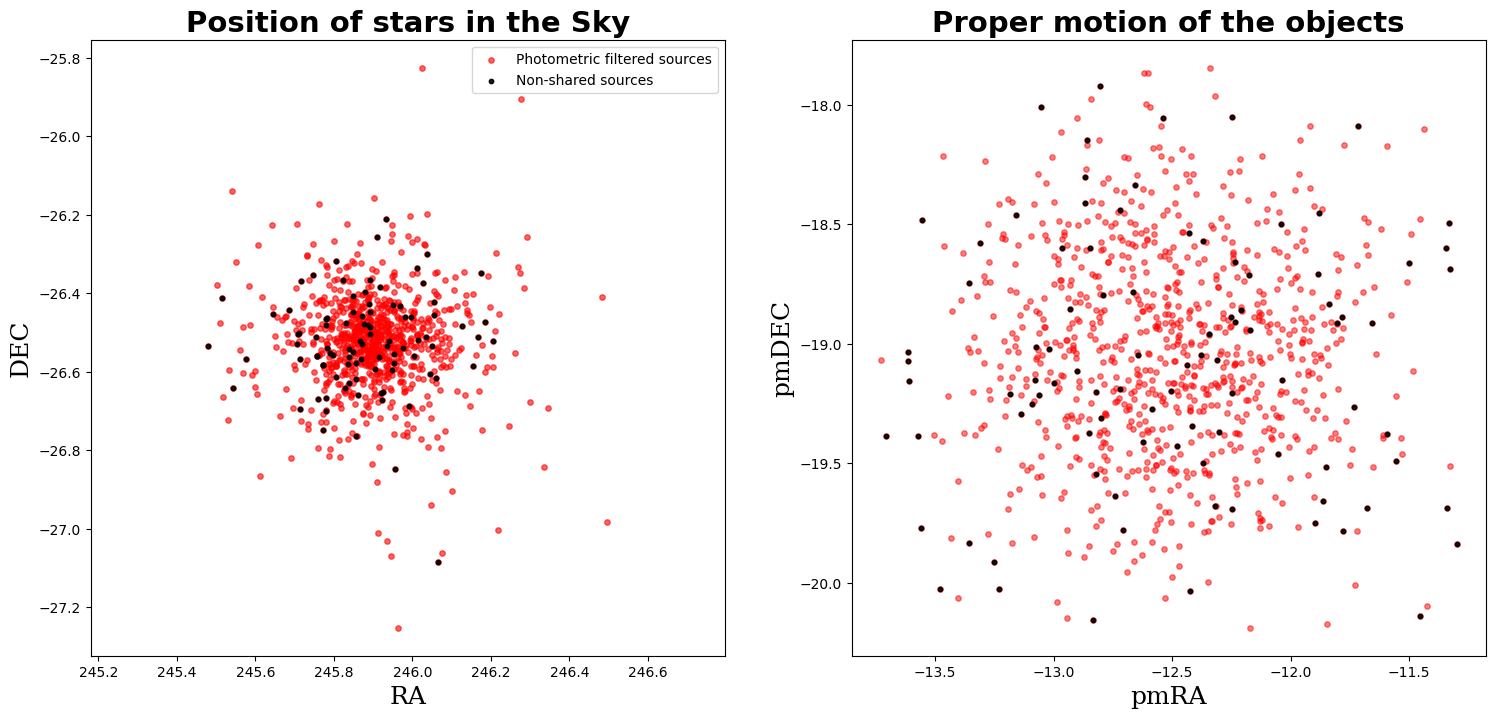

In [23]:
phot = m3_phot['source_id'].filled(fill_value=0)
astr = n6121c['source_id'].filled(fill_value=0)
shared = np.intersect1d(phot, astr)
plusSources_fromPhot = np.setdiff1d(phot, astr)

l=0
for i in range (0, len(plusSources_fromPhot)):
  for j in range (0, len(phot)):
    if plusSources_fromPhot[i] == phot[j] and m3_phot['pmdec'][j]<-16:
      l += 1

newSources = np.zeros((14, l))

k=0
for i in range (0, len(plusSources_fromPhot)):
  for j in range (0, len(phot)):
    if plusSources_fromPhot[i] == phot[j] and m3_phot['pmdec'][j]<-16:
      newSources[0][k] = m3_phot['parallax'][j]
      newSources[1][k] = m3_phot['parallax_error'][j]
      newSources[2][k] = m3_phot['ra'][j]
      newSources[3][k] = m3_phot['dec'][j]
      newSources[4][k] = m3_phot['ra_error'][j]
      newSources[5][k] = m3_phot['dec_error'][j]
      newSources[6][k] = m3_phot['ra_dec_corr'][j]
      newSources[7][k] = m3_phot['pmra'][j]
      newSources[8][k] = m3_phot['pmdec'][j]
      newSources[9][k] = m3_phot['pmra_error'][j]
      newSources[10][k] = m3_phot['pmdec_error'][j]
      newSources[11][k] = m3_phot['pmra_pmdec_corr'][j]
      newSources[12][k] = m3_phot['radial_velocity'][j]
      newSources[13][k] = m3_phot['radial_velocity_error'][j]
      k += 1

fig, axs = plt.subplots(1, 2, figsize=(18,8))
axs[0].axis('equal')
axs[0].scatter(m3_phot['ra'], m3_phot['dec'], c='red', alpha=0.6, label='Photometric filtered sources', s=15)
axs[0].scatter(newSources[2], newSources[3], c='black', alpha=0.9, label='Non-shared sources', s=10)
axs[0].set_title("Position of stars in the Sky", fontdict=title_font)
axs[0].set_xlabel("RA", fontdict=label_font)
axs[0].set_ylabel("DEC", fontdict=label_font)

#axs[1].scatter(m3_phot['pmra'], m3_phot['pmdec'], color='black', alpha=0.7, s=10)
axs[1].set_title("Proper motion of the objects", fontdict=title_font)
axs[1].set_xlabel("pmRA", fontdict=label_font)
axs[1].set_ylabel("pmDEC", fontdict=label_font)
axs[0].axis('equal')
axs[1].scatter(m3_phot['pmra'], m3_phot['pmdec'], c='red', alpha=0.5, s=15)
axs[1].scatter(newSources[7], newSources[8], c='black', alpha=0.9, s=10)

axs[0].legend(loc='best')

vc=0
for i in range (0,len(newSources)):
  if newSources[12][i] != np.nan:
    vc += 1

print('{:d} Sources are the same\n{:d} Non shared one\n{:d} New sources after cleaning respect to the astrometric selected sources'.format(len(shared), len(plusSources_fromPhot), len(newSources[5])))
print('{:d} New sources with radial velocity'.format(vc))

oldSources = np.zeros((14, len(n6121c['parallax'])))
oldSources[0] = n6121c['parallax']
oldSources[1] = n6121c['parallax_error']
oldSources[2] = n6121c['ra']
oldSources[3] = n6121c['dec']
oldSources[4] = n6121c['ra_error']
oldSources[5] = n6121c['dec_error']
oldSources[6] = n6121c['ra_dec_corr']
oldSources[7] = n6121c['pmra'] * (u.mas/u.yr)
oldSources[8] = n6121c['pmdec'] * (u.mas/u.yr)
oldSources[9] = n6121c['pmra_error'] * (u.mas/u.yr)
oldSources[10] = n6121c['pmdec_error'] * (u.mas/u.yr)
oldSources[11] = n6121c['pmra_pmdec_corr']
oldSources[12] = n6121c['radial_velocity']
oldSources[13] = n6121c['radial_velocity_error']

ap_sample = np.array([np.concatenate((oldSources[i], newSources[i])) for i in range(oldSources.shape[0])])

1014 total sources
91 with radial velocity


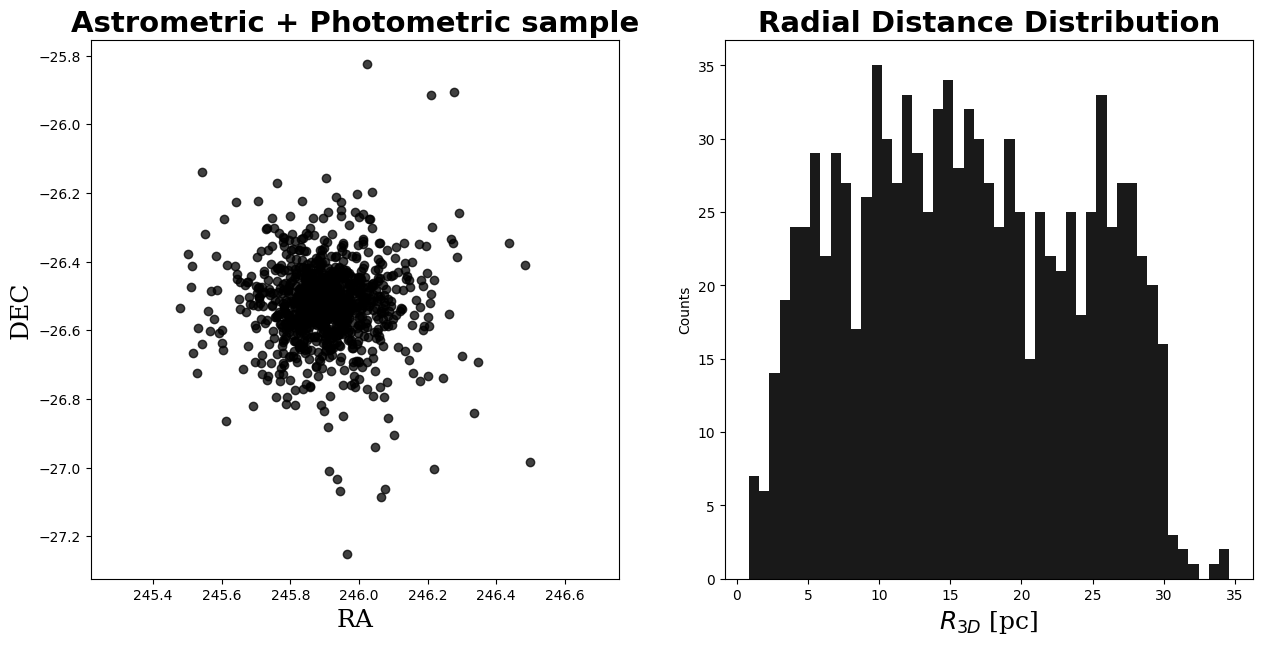

In [24]:
m4 = QTable()

# Coordinates in the GCRF
m4['x']       = (ap_sample[2] - NGC6121.ra.value) #deg
m4['y']       = (ap_sample[3] - NGC6121.dec.value) #deg
m4['x_error'] = ap_sample[4] #deg
m4['y_error'] = ap_sample[5] #deg
m4['xy_corr'] = ap_sample[6]

# Calcolo posizioni 3D
wp, wp_e = angular_distance(ap_sample[2], ap_sample[3], NGC6121.ra.value, NGC6121.dec.value, ra0_err=ap_sample[4], dec0_err=ap_sample[5], corr=ap_sample[6])
rp       = 1/ap_sample[0]
r2dp     = (NGC6121.distance.to(u.kpc).value * np.tan(wp*u.deg))
dp       = rp - NGC6121.distance.to(u.kpc).value

rp_e     = 1/ap_sample[0]**2 * ap_sample[1]
dp_e     = np.sqrt(rp_e**2 + D_err.to(u.kpc).value**2)
r2dp_e   = np.sqrt(NGC6121.distance.value**2*wp_e**2 + D_err.to(u.kpc).value**2)

m4['R']        = np.sqrt(dp**2 + r2dp.value**2)*1000 # pc
m4['R_error']  = 1/m4['R'] * np.sqrt(dp**2*dp_e**2 + r2dp**2*r2dp_e**2)

# Conversione velocità e calcolo velocità totale (con isotropia assunta)
ap_sample[7]   = ap_sample[7] * (u.mas/u.yr)
ap_sample[8]   = ap_sample[8] * (u.mas/u.yr)
ap_sample[9]   = ap_sample[9] * (u.mas/u.yr)
ap_sample[10]  = ap_sample[10] * (u.mas/u.yr)

temp2_vx        = (ap_sample[7]* (u.mas/u.yr)).to(u.rad/u.s) *NGC6121.distance.to(u.kpc).to(u.km) / u.rad
m4['vx']        = temp2_vx-np.mean(temp2_vx)
temp2_vy        = (ap_sample[8]* (u.mas/u.yr)).to(u.rad/u.s) *NGC6121.distance.to(u.kpc).to(u.km) / u.rad
m4['vy']        = temp2_vy-np.mean(temp2_vy)

vxerr2 = (ap_sample[9] *(u.mas/u.yr)).to(u.rad/u.s) * D/u.rad
vyerr2 = (ap_sample[9] *(u.mas/u.yr)).to(u.rad/u.s) * D/ u.rad

sigma2_vx = np.std(m4['vx'])
sigma2_vy = np.std(m4['vy'])

m4['vx_error'] = np.sqrt(D**2 * ((ap_sample[9] *(u.mas/u.yr)).to(u.rad/u.s))**2  + ((ap_sample[7]*(u.mas/u.yr)).to(u.rad/u.s))**2  * D_err**2)/u.rad
m4['vy_error'] = np.sqrt(D**2 * ((ap_sample[10]*(u.mas/u.yr)).to(u.rad/u.s))**2  + ((ap_sample[8]*(u.mas/u.yr)).to(u.rad/u.s))**2  * D_err**2)/u.rad
m4['v_corr']   = ap_sample[11]
m4['vr']       = ap_sample[12] *(u.km/u.s)
m4['vr_error'] = ap_sample[13] *(u.km/u.s)

sigma2_vr = np.nanstd(m4['vr'])

fig, axs = plt.subplots(1, 2, figsize=(15,7))
axs[0].scatter(ap_sample[2], ap_sample[3], color='black', alpha=0.75)
axs[0].set_xlabel('RA', fontdict=label_font)
axs[0].set_ylabel('DEC', fontdict=label_font)
axs[0].set_title('Astrometric + Photometric sample', fontdict=title_font)
axs[1].hist(m4['R'], bins=bins_(1014), color='black', alpha=0.9)
axs[1].set_xlabel(r'$R_{3D}$ [pc]', fontdict=label_font)
axs[1].set_ylabel('Counts')
axs[1].set_title('Radial Distance Distribution', fontdict=title_font)
axs[0].axis('equal')
output.clear()

n_vr = N_v

print('{:d} total sources\n{:d} with radial velocity'.format(len(m4['vx']), n_vr))

Text(0, 0.5, '$v_y$ $[{\\rm km\\,s^{-1}}]$')

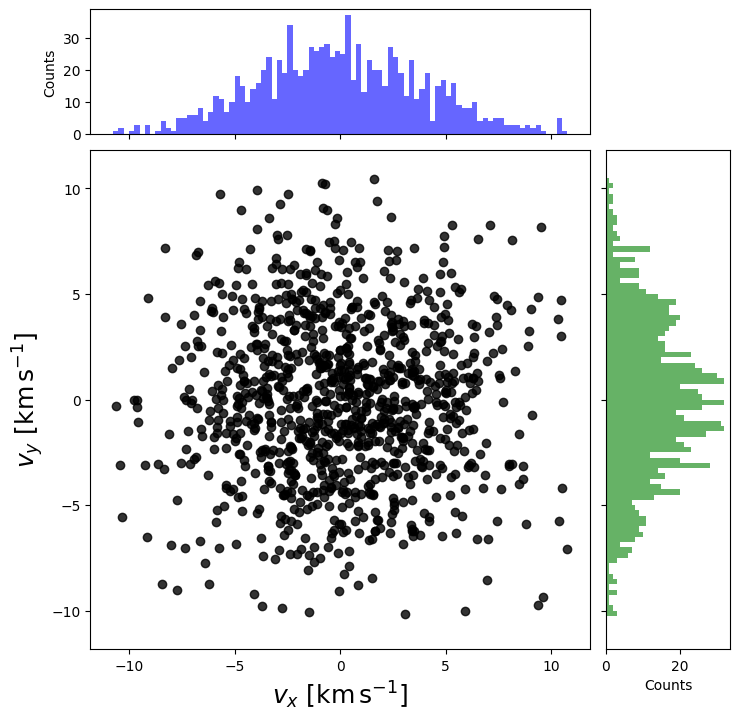

In [25]:
fig = plt.figure(figsize=(8,8))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(m4['vx'].value, m4['vy'].value, ax, ax_histx, ax_histy)
ax_histx.set_ylabel('Counts')
ax_histy.set_xlabel('Counts')
ax.set_xlabel(r'$v_x$ $[{\rm km\,s^{-1}}]$', fontdict=label_font)
ax.set_ylabel(r'$v_y$ $[{\rm km\,s^{-1}}]$', fontdict=label_font)

In [26]:
tempx_m = np.mean(temp2_vx)
tempy_m = np.mean(temp2_vy)

tempx_e = np.sqrt(sum((i*i) for i in m4['vx_error']))/len(m4['vx'])
tempy_e = np.sqrt(sum((i*i) for i in m4['vy_error']))/len(m4['vy'])

print('<v_x> = {:.3f} +- {:.3f}'.format(tempx_m, tempx_e))
print('<v_y> = {:.3f} +- {:.3f}'.format(tempy_m, tempy_e))

<v_x> = -109.856 km / s +- 0.070 km / s
<v_y> = -167.003 km / s +- 0.062 km / s


pmra_mean  = -12.52 +- 0.23 mas/yr
pmdec_mean = -19.03 +- 0.16 mas/yr


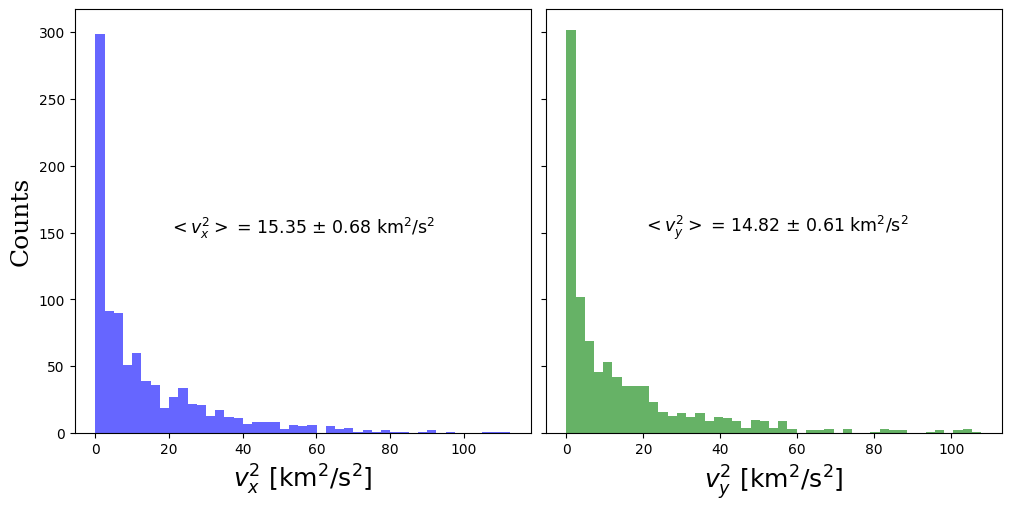

In [27]:
vx2 = (m4['vx'])**2
vy2 = (m4['vy'])**2

sigma2_vx2 = np.std(vx2)
sigma2_vy2 = np.std(vy2)

vx2_e = 2*m4['vx']*vxerr2#m4['vx_error']
vy2_e = 2*m4['vy']*vyerr2#m4['vy_error']

vx2_avg_err = np.sqrt(sum((i*i) for i in vx2_e))/len(vx2)
vy2_avg_err = np.sqrt(sum((i*i) for i in vy2_e))/len(vy2)

fig, axs = plt.subplots(1,2,figsize=(10,5), layout='constrained', sharey=True)
fig = plt.subplots_adjust(wspace=0)
vx2h = axs[0].hist(vx**2, bins=n_bin, color='blue', alpha=0.6)
vy2h = axs[1].hist(vy**2, bins=n_bin, color='green', alpha=0.6)
axs[0].set_xlabel(r'$v_x^2$ $[{\rm km^2/s^{2}}]$', fontdict=label_font)
axs[0].set_ylabel('Counts', fontdict=label_font)
axs[1].set_xlabel(r'$v_y^2$ $[{\rm km^2/s^{2}}]$', fontdict=label_font)
axs[0].text(20 ,vx2h[0].max()/2, r'$<v_x^2>$ = {:.2f} $\pm$ {:.2f} km$^2$/s$^2$'.format(np.mean(vx2).value, vx2_avg_err.value), fontsize=12.5)
axs[1].text(20 ,vy2h[0].max()/2, r'$<v_y^2>$ = {:.2f} $\pm$ {:.2f} km$^2$/s$^2$'.format(np.mean(vy2).value, vy2_avg_err.value), fontsize=12.5)

print('pmra_mean  = {:.2f} +- {:.2f} mas/yr\npmdec_mean = {:.2f} +- {:.2f} mas/yr'.format(ap_sample[7].mean(), np.sqrt(sum(i*i for i in ap_sample[9])/len(ap_sample[7])),
                                                                           ap_sample[8].mean(), np.sqrt(sum(i*i for i in ap_sample[10])/len(ap_sample[8]))))

In [28]:
#esempio di calcolo di errore sulla velocità media
conversion_error = (0.23*u.mas/u.yr).to(u.rad/u.s) * D/u.rad
computed_error   = np.sqrt(D**2 * ((0.23*(u.mas/u.yr)).to(u.rad/u.s))**2  + ((12.52*(u.mas/u.yr)).to(u.rad/u.s))**2  * D_err**2)/u.rad

print('Conversion error: {:f} \nComputed error: {:f}'.format(conversion_error, computed_error))
print('Scarto dello {:.2f}%'.format((1-conversion_error/computed_error) * 100))

Conversion error: 2.018160 km / s 
Computed error: 2.217939 km / s
Scarto dello 9.01%


Text(0, 0.5, 'Counts')

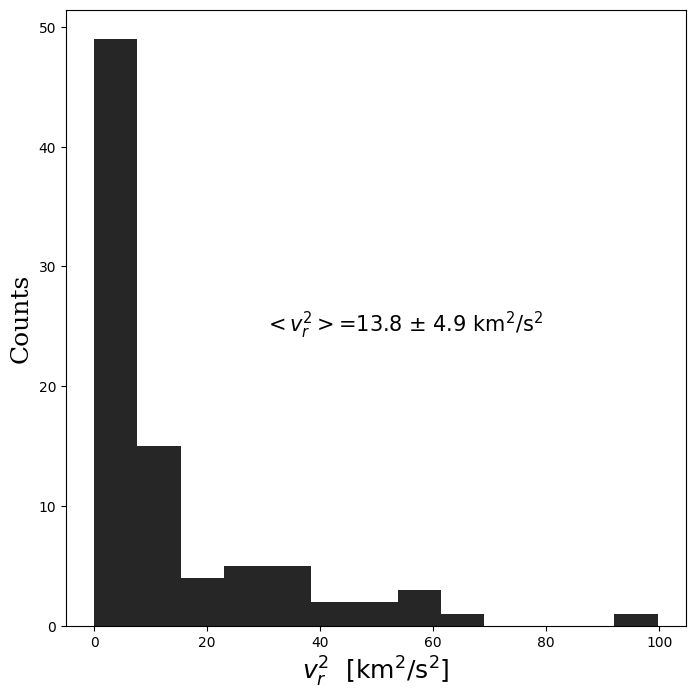

In [33]:
sigma_los = np.nanstd(ap_sample[12])
vlos_max = np.nanmean(ap_sample[12]) + 2.355*sigma_los
vlos_min = np.nanmean(ap_sample[12]) - 2.355*sigma_los

j=0
for x in range (0, N):
  if (ap_sample[12][x] < vlos_max) and (ap_sample[12][x] > vlos_min):
    j+=1

nv2 = bins_(j)
v_los2 = np.zeros((3, j))        # [0]:R ; [1]:VR ; [2]:VR_ERROR

j=0

for x in range (0, N):
  if (ap_sample[12][x] < vlos_max) and (ap_sample[12][x] > vlos_min):
    v_los2[1][j] = ap_sample[12][x]
    v_los2[2][j] = ap_sample[13][x]
    v_los2[0][j] = m4['R'][x]
    j += 1

v_GCRF = v_los2[1] - np.mean(v_los2[1])
sigma3_vr = np.std(v_GCRF)

vlos_2m = np.mean(v_los2[1])
vlos_2e = np.sqrt(sum(i*i for i in v_los2[2]))/len(v_los2[0])
vr2_2e = 2*v_GCRF*v_los2[2]
vr2m_2e = np.sqrt(sum(i*i for i in vr2_2e))/len(v_los2[0])

fig, ax = plt.subplots(1,1,figsize=(8,8))
vh2 = plt.hist(v_GCRF**2, bins=bins_(j), color='black', alpha=0.85)
ax.text(30, vh2[0].max()/2, r'$<v_r^2>$={:.1f} $\pm$ {:.1f} km$^2$/s$^2$'.format(np.mean(v_GCRF**2), vr2m_2e), fontsize=15)
plt.xlabel(r'$v_r^2$  $[{\rm km^2/s^2}]$', fontdict=label_font)
plt.ylabel('Counts', fontdict=label_font)

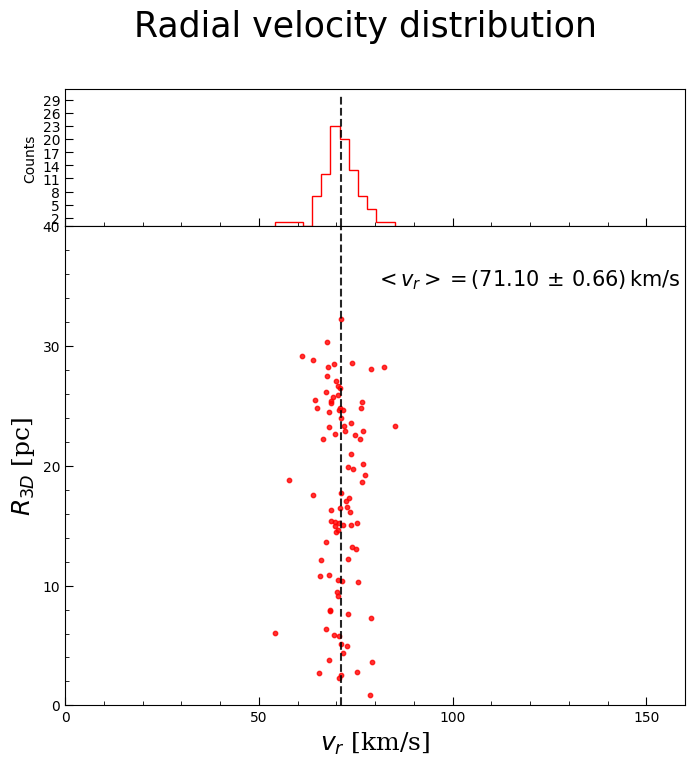

In [30]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, height_ratios=[1,3.5], figsize=(8,8), sharex=True)
fig.subplots_adjust(hspace=0)

ax1.scatter(m4['vr'], m4['R'], c='red', alpha=0.8, s=10)
#ax0.errorbar(R, v_los, yerr=v_los_err, fmt=' ', color='black', linewidth=1.5)
ax1.set_xticks(np.arange(-300, 300, 100))
ax1.set_yticks(np.arange(-10, 100, 10))
ax1.set_xlim(0,160)#-210,280)
ax1.set_ylim(0, 40)

#Media scritta
ax1.text(80, 35, r'$<v_r>=(${:.2f}$\,\pm\,${:.2f}$)\,$km/s'.format(np.nanmean(m4['vr'].value), vlos_2e), color='black', fontsize=15)

ax0.hist(m4['vr'], bins=nv2, color='red', histtype='step', orientation='vertical')
ax0.set_xticks(np.arange(-300, 300, 50))
ax0.set_yticks(np.arange(2, 30, 3))
ax0.set_xlim(0,160)#-210, 280)

#linea
ax1.plot( [np.nanmean(m4['vr'].value), np.nanmean(m4['vr'].value)], [0, 50], linestyle='--', c='black', alpha=0.85)
ax0.plot( [np.nanmean(m4['vr'].value), np.nanmean(m4['vr'].value)], [0, 30],  linestyle='--', c='black', alpha=0.85)

#labels
ax1.set_ylabel(r'$R_{3D}$ [pc]', fontdict=label_font)
ax1.set_xlabel(r'$v_r$ [km/s]', fontdict=label_font)
ax0.set_ylabel('Counts')

#minor ticks
ax0.minorticks_on()
ax1.minorticks_on()

ax0.tick_params(axis="both",direction="in", size=6)
ax0.tick_params(axis='y', which="minor",direction="in", size=0)
ax0.tick_params(axis='x', which="minor",direction="in", size=3)
ax1.tick_params(axis="both",direction="in", size=6)
ax1.tick_params(which="minor",direction="in", size=3)

fig = plt.suptitle('Radial velocity distribution', fontsize=25)

plt.show()

Calculated from data:
<V^2> = 45.25 +- 1.38 km2 / s2
Calculated from previous calculus:
<V^2> = 43.92 +- 0.80 km2 / s2

Scarto del -3.029 %


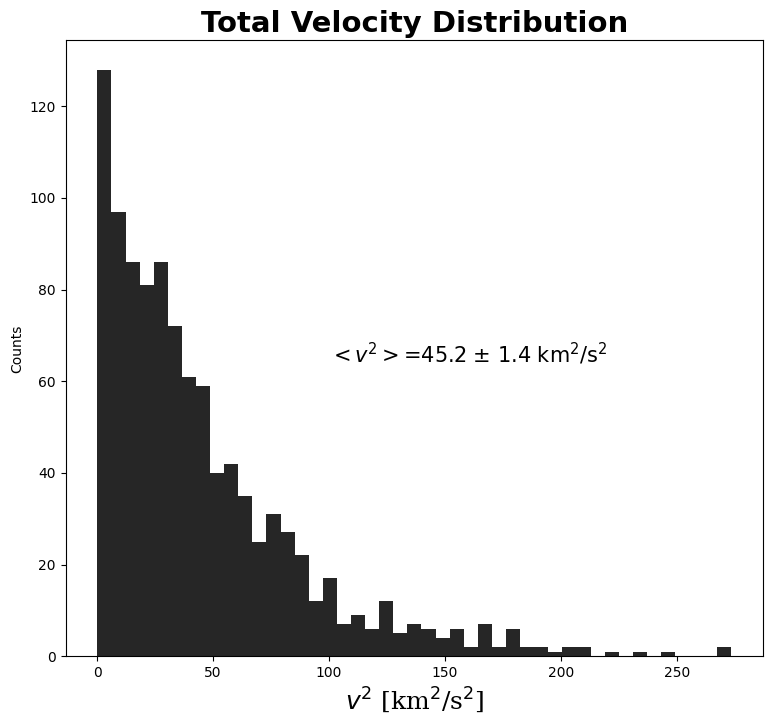

In [31]:
print('s(x)={:.3f} ; s(y)={:.3f} ; s(r)={:.3f} km/s'.format(sigma2_vx, sigma2_vy, sigma3_vr))
sigmaC = (np.sqrt(sigma2_vx.value**2 + sigma2_vy.value**2 + sigma3_vr**2))*(1+(w1.max()/0.86)**2)**0.25
print('\nS(0) = {:.3f} km/s'.format(sigmaC))

# Total squared velocity (on isotropy assumption)
V2 = 1.5*(vx2 + vy2)
V2_e = 1.5*np.sqrt(vx2_e**2 + vy2_e**2)

V2_m = np.average(V2)
V2m_e = np.sqrt(sum(i*i for i in V2_e))/len(V2)

fig, ax = plt.subplots(figsize=(9,8))
v2h = plt.hist(V2, bins=n_bin, color='black', alpha=0.85)
ax.text(100, v2h[0].max()/2, r'$<v^2>$={:.1f} $\pm$ {:.1f} km$^2$/s$^2$'.format(V2_m.value, V2m_e.value), fontsize=15)
plt.ylabel('Counts')
plt.xlabel(r'$v^2$ [km$^2$/s$^2$]', fontdict=label_font)
plt.title('Total Velocity Distribution', fontdict=title_font)
output.clear()

print('Calculated from data:\n<V^2> = {:.2f} +- {:.2f}'.format(V2_m.value, V2m_e))
print('Calculated from previous calculus:\n<V^2> = {:.2f} +- {:.2f} km2 / s2'.format((np.mean(vx2).value+np.mean(vy2).value+np.mean(v_GCRF**2)),
                                                                            np.sqrt(vx2_avg_err.value**2 + vy2_avg_err.value**2 + vr2m_2e)/3))
print('\nScarto del {:.3f} %'.format((1-V2_m.value/(np.mean(vx2).value+np.mean(vy2).value+np.mean(v_GCRF**2)))*100))

v2data = {'v^2': V2,
          'v^2_error': V2_e,
          'R': m4['R'],
          'R_error': m4['R_error']}

VD = pd.DataFrame(data=v2data)
VD.to_csv('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/V2.txt', sep='\t')


In [32]:
print('s_tot = {:.2f}'.format(np.std(V2)))
print('s_x = {:.2f}+-   s_y = {:.2f}+-   s_r = {:.2f}+- km / s'.format(sigma2_vx, sigma2_vy, sigma3_vr))

s_tot = 43.10 km2 / s2
s_x = 3.92 km / s+-   s_y = 3.85 km / s+-   s_r = 3.71+- km / s


# Creazione Dati per le Shells

Dati Merafina.

Calcoliamo il potenziale efficace sulla singola shell. Le shell scelte, numerate in base alla distanza, sono:

nr. 2 $\rightarrow$ $R\simeq 5.15{\rm pc}$

nr. 5 $\rightarrow$ $R\simeq 15.45{\rm pc}$

nr. 8 $\rightarrow$ $R\simeq 25.75{\rm pc}$

La width della shell è $\Delta R = 3.46$ pc

Aggiungere condizione `and V2[i].value < "valore tale da escludere"`


v^2_s,max = 137.232 +- 50.747
Relative error: 36.98%


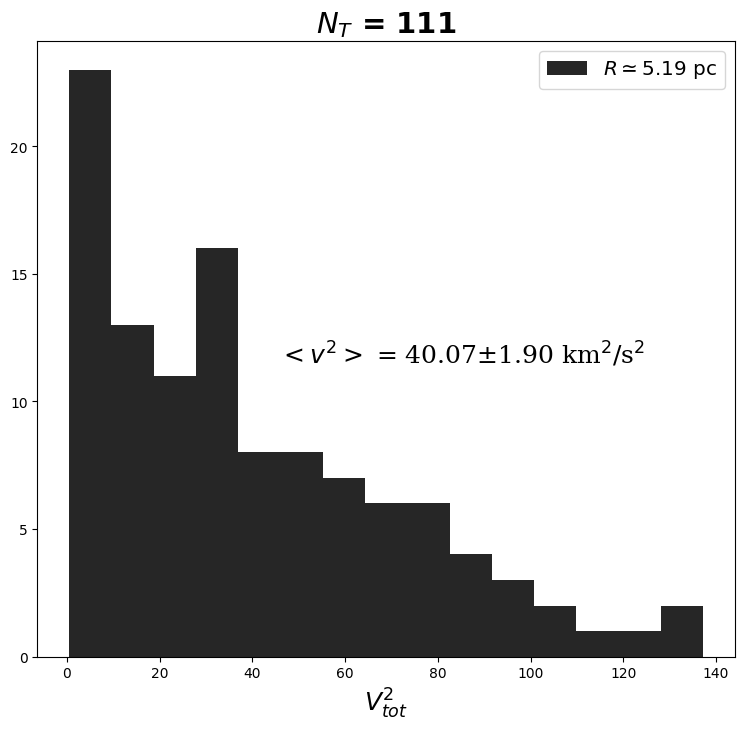

In [ ]:
mm1 = 0.10*(m4['R']).max()
mm2 = 0.20*(m4['R']).max()
jj=0
for i in range (0, N):
  if (m4['R'][i] > mm1 and m4['R'][i] <mm2 and V2[i].value<150):
    jj += 1

mmShell = np.zeros((3,jj))
mmbin = bins_(jj)

jj=0
for i in range (0, N):
  if (m4['R'][i] > mm1 and m4['R'][i] <mm2 and V2[i].value<150):

    mmShell[0][jj] = m4['R'][i]
    mmShell[1][jj] = V2[i].value
    mmShell[2][jj] = V2_e[i].value

    jj += 1

dvv = mmShell[1].max()/mmbin

vvi = np.zeros(mmbin+1)
vvo = np.zeros(mmbin+1)
vvi[0] = 0
vvo[0] = dvv

for jj in range (0, mmbin):

  vvi[jj+1] = vvi[jj] + dvv
  vvo[jj+1] = vvo[jj] + dvv

vvc = (vvo+vvi)/2

fig, ax = plt.subplots(figsize=(9,8))
mmh = plt.hist(mmShell[1], bins=mmbin, color='black', alpha=0.85, label=r'$R\simeq${:.2f} pc'.format(0.5*(mm1+mm2)))
ax.text(np.nanmax(mmShell[1])/3, mmh[0].max()/2, r'$<v^2>$ = {:.2f}$\pm${:.2f} km$^2/$s$^2$'.format(np.nanmean(mmShell[1]), np.sqrt(sum(i*i for i in mmShell[2]))/len(mmShell[2])), fontdict=label_font)
plt.xlabel(r'$V^2_{tot}$', fontdict=label_font)
plt.title(r'$N_T$ = {:d}'.format(len(mmShell[0])), fontdict=title_font)
plt.legend(fontsize='x-large')
output.clear()

print('v^2_s,max = {:.3f} +- {:.3f}'.format(mmShell[1][15],mmShell[2][15]))
print('Relative error: {:.2f}%'.format(mmShell[2][15]/mmShell[1][15] *100))

v^2_s,max = 155.26 +- 36.58
Relative error: 23.56%


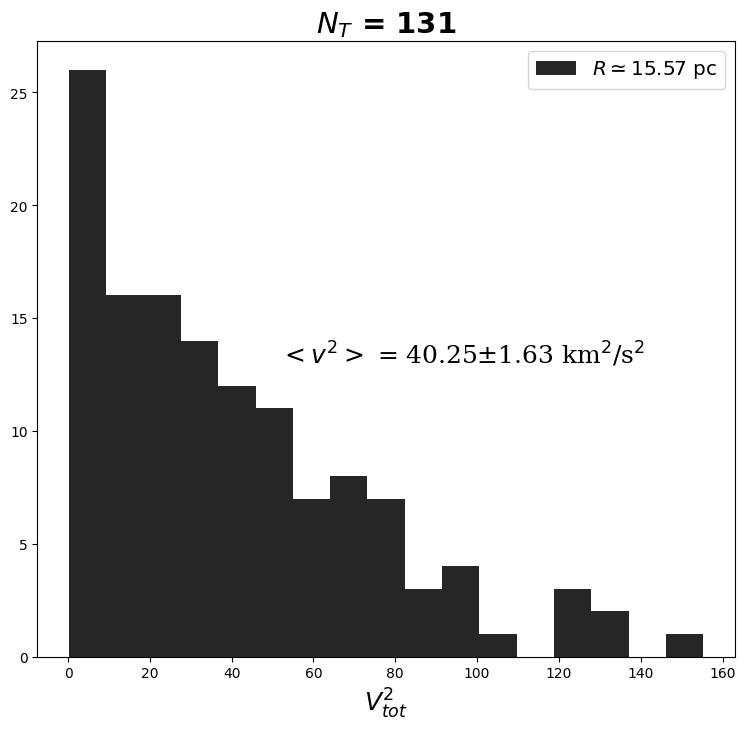

In [ ]:
m1 = 0.40*(m4['R']).max()
m2 = 0.50*(m4['R']).max()
j=0
for i in range (0, N):
  if (m4['R'][i] > m1 and m4['R'][i] <m2 and V2[i].value<156):
    j += 1

mShell = np.zeros((3,j))
mbin = bins_(j)
j=0
for i in range (0, N):
  if (m4['R'][i] > m1 and m4['R'][i] <m2 and V2[i].value<156):

    mShell[0][j] = m4['R'][i]
    mShell[1][j] = V2[i].value
    mShell[2][j] = V2_e[i].value

    j += 1

dv = mShell[1].max()/mbin

vi = np.zeros(mbin+1)
vo = np.zeros(mbin+1)
vi[0] = 0
vo[0] = dv

for j in range (0, mbin):

  vi[j+1] = vi[j] + dv
  vo[j+1] = vo[j] + dv

vc = (vo+vi)/2


fig, ax = plt.subplots(figsize=(9,8))
mh = plt.hist(mShell[1], bins=mbin, color='black', alpha=0.85, label=r'$R\simeq${:.2f} pc'.format(0.5*(m1+m2)))
ax.text(np.nanmax(mShell[1])/3, mh[0].max()/2, r'$<v^2>$ = {:.2f}$\pm${:.2f} km$^2/$s$^2$'.format(np.nanmean(mShell[1]), np.sqrt(sum(i*i for i in mShell[2]))/len(mShell[2])), fontdict=label_font)
plt.xlabel(r'$V^2_{tot}$', fontdict=label_font)
plt.title(r'$N_T$ = {:d}'.format(len(mShell[0])), fontdict=title_font)
plt.legend(fontsize='x-large')
output.clear()

print('v^2_s,max = {:.2f} +- {:.2f}'.format(mShell[1][3],mShell[2][3]))
print('Relative error: {:.2f}%'.format(mShell[2][3]/mShell[1][3] *100))

v^2_s,max = 168.743 +- 30.429
Relative error: 18.03%


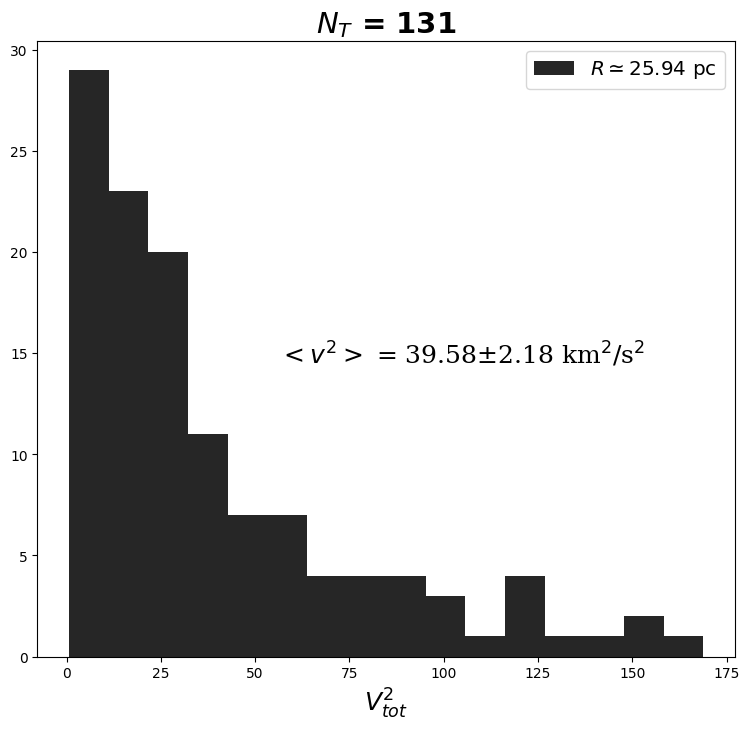

In [ ]:
mmm1 = 0.70*(m4['R']).max()
mmm2 = 0.80*(m4['R']).max()

jjj=0
for i in range (0, N):
  if (m4['R'][i] > mmm1 and m4['R'][i] <mmm2 and V2[i].value<170):
    jjj += 1

mmmShell = np.zeros((3,jjj))
mmmbin = bins_(jjj)

jjj=0
for i in range (0, N):
  if (m4['R'][i] > mmm1 and m4['R'][i] <mmm2 and V2[i].value<170):

    mmmShell[0][jjj] = m4['R'][i]
    mmmShell[1][jjj] = V2[i].value
    mmmShell[2][jjj] = V2_e[i].value

    jjj += 1

dddv = mmmShell[1].max()/mmmbin

vvvi = np.zeros(mmmbin+1)
vvvo = np.zeros(mmmbin+1)
vvvi[0] = 0
vvvo[0] = dddv

for j in range (0, mmmbin):

  vvvi[j+1] = vvvi[j] + dddv
  vvvo[j+1] = vvvo[j] + dddv

vvvc = (vvvo+vvvi)/2

fig, ax = plt.subplots(figsize=(9,8))
mmmh = plt.hist(mmmShell[1], bins=mmmbin, color='black', alpha=0.85, label=r'$R\simeq${:.2f} pc'.format(0.5*(mmm1+mmm2)))
ax.text(mmmShell[1].max()/3, mmmh[0].max()/2, r'$<v^2>$ = {:.2f}$\pm${:.2f} km$^2/$s$^2$'.format(np.average(mmmShell[1]), np.sqrt(sum(i*i for i in mmmShell[2]))/len(mmmShell[2])), fontdict=label_font)
plt.xlabel(r'$V^2_{tot}$', fontdict=label_font)
plt.title(r'$N_T$ = {:d}'.format(len(mShell[0])), fontdict=title_font)
plt.legend(fontsize='x-large')
output.clear()

print('v^2_s,max = {:.3f} +- {:.3f}'.format(mmmShell[1][28],mmmShell[2][28]))
print('Relative error: {:.2f}%'.format(mmmShell[2][28]/mmmShell[1][28] *100))

In [ ]:
dx = V2.value.max()/n_bin

xi = np.zeros(n_bin+1)
xo = np.zeros(n_bin+1)
xi[0] = 0
xo[0] = dx

for j in range (0, n_bin):

  xi[j+1] = xi[j] + dx
  xo[j+1] = xo[j] + dx

xc = (xo+xi)/2

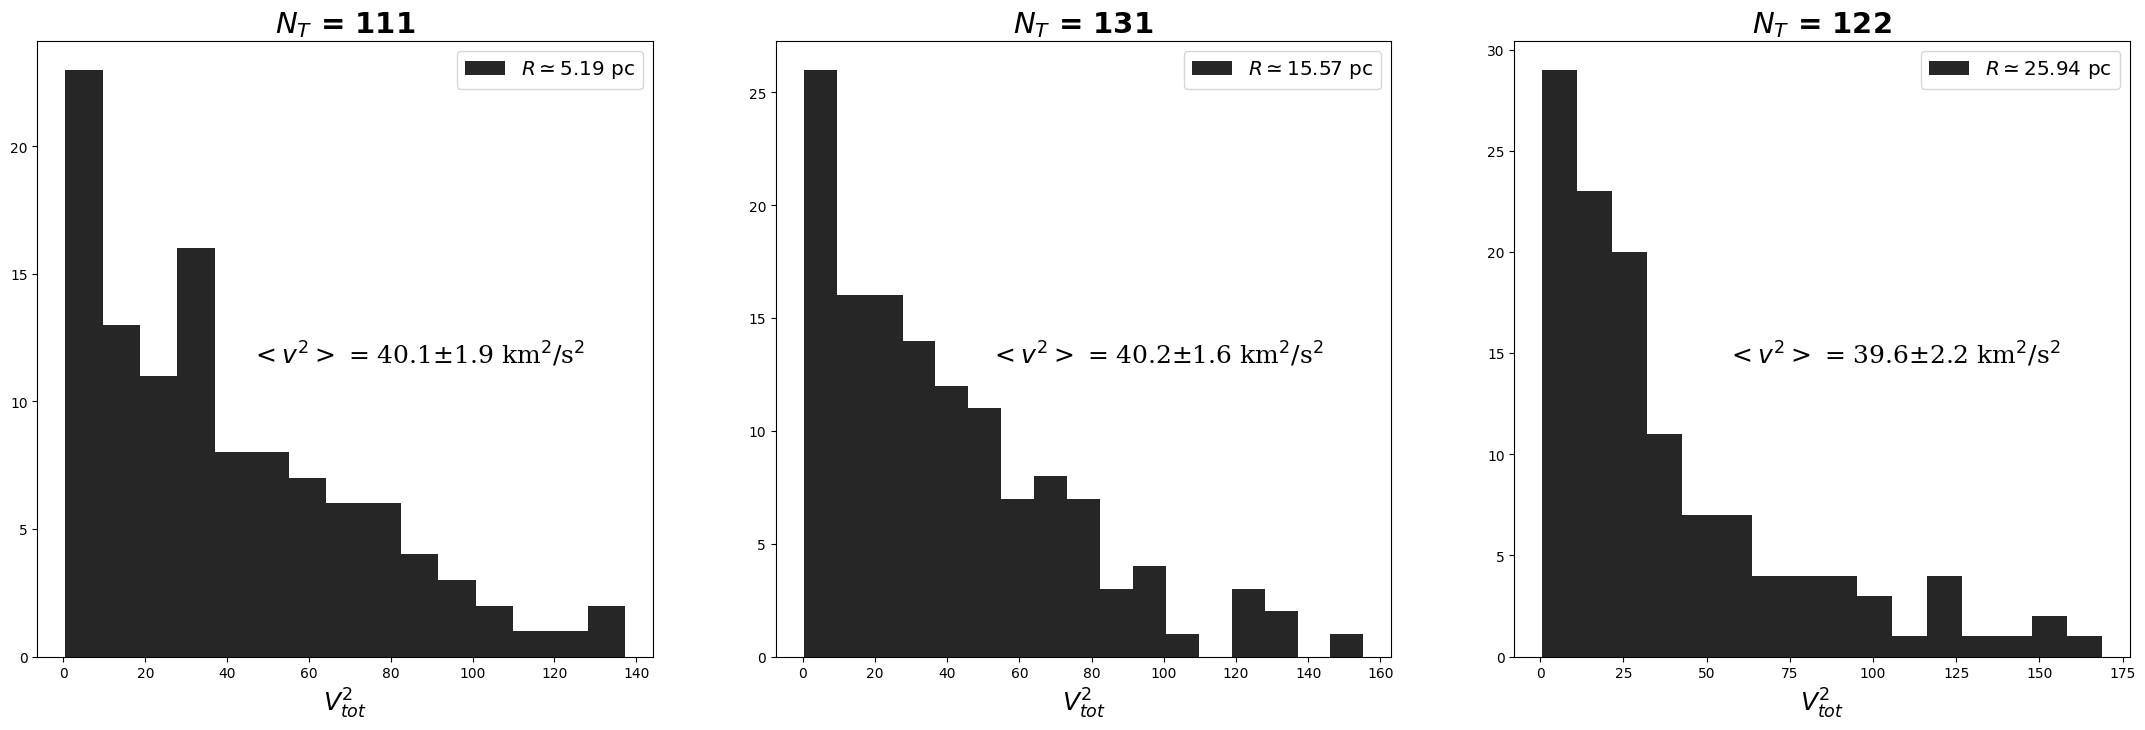

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(27,8))
mh = axs[1].hist(mShell[1], bins=mbin, color='black', alpha=0.85, label=r'$R\simeq${:.2f} pc'.format(0.5*(m1+m2)))
axs[1].text(np.nanmax(mShell[1])/3, mh[0].max()/2, r'$<v^2>$ = {:.1f}$\pm${:.1f} km$^2/$s$^2$'.format(np.nanmean(mShell[1]), np.sqrt(sum(i*i for i in mShell[2]))/len(mShell[2])), fontdict=label_font)
axs[1].set_xlabel(r'$V^2_{tot}$', fontdict=label_font)
axs[1].set_title(r'$N_T$ = {:d}'.format(len(mShell[0])), fontdict=title_font)
axs[1].legend(fontsize='x-large')

mmh = axs[0].hist(mmShell[1], bins=mmbin, color='black', alpha=0.85, label=r'$R\simeq${:.2f} pc'.format(0.5*(mm1+mm2)))
axs[0].text(mmShell[1].max()/3, mmh[0].max()/2, r'$<v^2>$ = {:.1f}$\pm${:.1f} km$^2/$s$^2$'.format(np.average(mmShell[1]), np.sqrt(sum(i*i for i in mmShell[2]))/len(mmShell[2])), fontdict=label_font)
axs[0].set_xlabel(r'$V^2_{tot}$', fontdict=label_font)
axs[0].set_title(r'$N_T$ = {:d}'.format(len(mmShell[0])), fontdict=title_font)
axs[0].legend(fontsize='x-large')

mmmh = axs[2].hist(mmmShell[1], bins=mmmbin, color='black', alpha=0.85, label=r'$R\simeq${:.2f} pc'.format(0.5*(mmm1+mmm2)))
axs[2].text(mmmShell[1].max()/3, mmmh[0].max()/2, r'$<v^2>$ = {:.1f}$\pm${:.1f} km$^2/$s$^2$'.format(np.average(mmmShell[1]), np.sqrt(sum(i*i for i in mmmShell[2]))/len(mmmShell[2])), fontdict=label_font)
axs[2].set_xlabel(r'$V^2_{tot}$', fontdict=label_font)
axs[2].set_title(r'$N_T$ = {:d}'.format(len(mmmShell[0])), fontdict=title_font)
axs[2].legend(fontsize='x-large')

output.clear()

In [ ]:
mdata = {'N bin': mh[0],
         'Central Bin V^2 [km2/s2]': vc[0:mbin],
         'Inner V^2': vi[0:mbin],
         'Outer V^2': vo[0:mbin],
         '<V^2>={:f}+-{:f} km2/s2'.format(np.average(mShell[1]), np.sqrt(sum(i*i for i in mShell[2]))/len(mShell[2])): '',
         'delta R={:f}'.format(m2-m1): '',
         'Shell distance from centre={:f}'.format((m2+m1)/2): ''}

MM = pd.DataFrame(data=mdata)
MM.to_csv('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/V2_shell5.txt', sep='\t')

mmdata = {'N bin': mmh[0],
         'Central Bin V^2 [km2/s2]': vvc[0:mmbin],
         'Inner V^2': vvi[0:mmbin],
         'Outer V^2': vvo[0:mmbin],
         '<V^2>={:f}+-{:f} km2/s2'.format(np.average(mmShell[1]), np.sqrt(sum(i*i for i in mmShell[2]))/len(mmShell[2])): '',
         'delta R={:f}'.format(mm2-mm1): '',
         'Shell distance from centre={:f}'.format((mm2+mm1)/2): ''}

MM = pd.DataFrame(data=mmdata)
MM.to_csv('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/V2_shell2.txt', sep='\t')

mmmdata = {'N bin': mmmh[0],
         'Central Bin V^2 [km2/s2]': vvvc[0:mmmbin],
         'Inner V^2': vvvi[0:mmmbin],
         'Outer V^2': vvvo[0:mmmbin],
         '<V^2>={:f}+-{:f} km2/s2'.format(np.average(mmmShell[1]), np.sqrt(sum(i*i for i in mmmShell[2]))/len(mmmShell[2])): '',
         'delta R={:f}'.format(mmm2-mmm1): '',
         'Shell distance from centre={:f}'.format((mmm2+mmm1)/2): ''}

MM = pd.DataFrame(data=mmmdata)
MM.to_csv('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/V2_shell8.txt', sep='\t')

tdata = {'N bin': v2h[0],
         'Central Bin V^2': xc[0:n_bin],
         'Inner V^2': xi[0:n_bin],
         'Outer V^2': xo[0:n_bin],
         '<V^2>={:f}+-{:f} km2/s2'.format(V2_m, V2m_e): '',
         'DR={:f}'.format(R.max()): '',
         'Shell distance from centre={:f}'.format(R.max()/2): ''}

TV = pd.DataFrame(data=tdata)
TV.to_csv('/content/gdrive/MyDrive/Tesi_di_laurea/Data/SampleData/V2_tot.txt', sep='\t')

# Grafici, disegni e prove

In [ ]:
gaiadr3_table = Gaia.load_table('gaiadr3.gaia_source')
i=0
for column in gaiadr3_table.columns:
  print(i, column.name)
  i+=1

Retrieving table 'gaiadr3.gaia_source'
0 solution_id
1 designation
2 source_id
3 random_index
4 ref_epoch
5 ra
6 ra_error
7 dec
8 dec_error
9 parallax
10 parallax_error
11 parallax_over_error
12 pm
13 pmra
14 pmra_error
15 pmdec
16 pmdec_error
17 ra_dec_corr
18 ra_parallax_corr
19 ra_pmra_corr
20 ra_pmdec_corr
21 dec_parallax_corr
22 dec_pmra_corr
23 dec_pmdec_corr
24 parallax_pmra_corr
25 parallax_pmdec_corr
26 pmra_pmdec_corr
27 astrometric_n_obs_al
28 astrometric_n_obs_ac
29 astrometric_n_good_obs_al
30 astrometric_n_bad_obs_al
31 astrometric_gof_al
32 astrometric_chi2_al
33 astrometric_excess_noise
34 astrometric_excess_noise_sig
35 astrometric_params_solved
36 astrometric_primary_flag
37 nu_eff_used_in_astrometry
38 pseudocolour
39 pseudocolour_error
40 ra_pseudocolour_corr
41 dec_pseudocolour_corr
42 parallax_pseudocolour_corr
43 pmra_pseudocolour_corr
44 pmdec_pseudocolour_corr
45 astrometric_matched_transits
46 visibility_periods_used
47 astrometric_sigma5d_max
48 matched_trans

In [ ]:
np.random.seed(165498401)

data_x = np.random.rand(100)*100
errors_x = np.random.rand(100)/10
mean_x = np.mean(data_x)
std_x = np.std(data_x)

# 1: Arithmetic Mean Error

AME = std_x/np.sqrt(100)

# 2: Weighted Mean Error

WME = 1/np.sqrt(sum(1/(i*i) for i in errors_x))

# 3: Propagation Method Error

PME = np.sqrt(sum(i*i for i in errors_x))

# 4: Particular case of WME

P_WME = std_x*1/np.sqrt(sum(1/(i*i) for i in errors_x))
print('AME = {:f}\nWME = {:f}\nPME = {:f}\nP_WME = {:f}'.format(AME, WME, PME, P_WME))

# Confronto tra gli errori della media
summ=0
for i in range (0, N):
  summ += (vx2[i] - vx2.mean())**2/(vx2_e[i]**2)

SEM_p = np.sqrt( summ / (N*(N-1)))

PEM = np.sqrt( sum((i**2) for i in vx2_e))/N

PEM_gpt = np.sqrt( sum((i**2) for i in vx2_e)/N )

SEM = np.std(vx2)/N**0.5

print('Errore pesato sugli errori e la statistica del campione (gpt)\n{:.2f} +- {:.2f} km2 / s2'.format(vx2.mean().value, SEM_p))
print('Errore con la propagazione (mio)\n{:.2f} +- {:.2f}'.format(vx2.mean().value, PEM))
print('Errore con la propagazione (gpt)\n{:.2f} +- {:.2f}'.format(vx2.mean().value, PEM_gpt))
print('Errore statistico del campione (con sigma)\n{:.2f} +- {:.2f}'.format(vx2.mean().value, SEM))

AME = 2.733693
WME = 0.000728
PME = 0.606482
P_WME = 0.019897
Errore pesato sugli errori e la statistica del campione (gpt)
15.35 +- 2.64 km2 / s2
Errore con la propagazione (mio)
15.35 +- 0.75 km2 / s2
Errore con la propagazione (gpt)
15.35 +- 22.86 km2 / s2
Errore statistico del campione (con sigma)
15.35 +- 0.67 km2 / s2


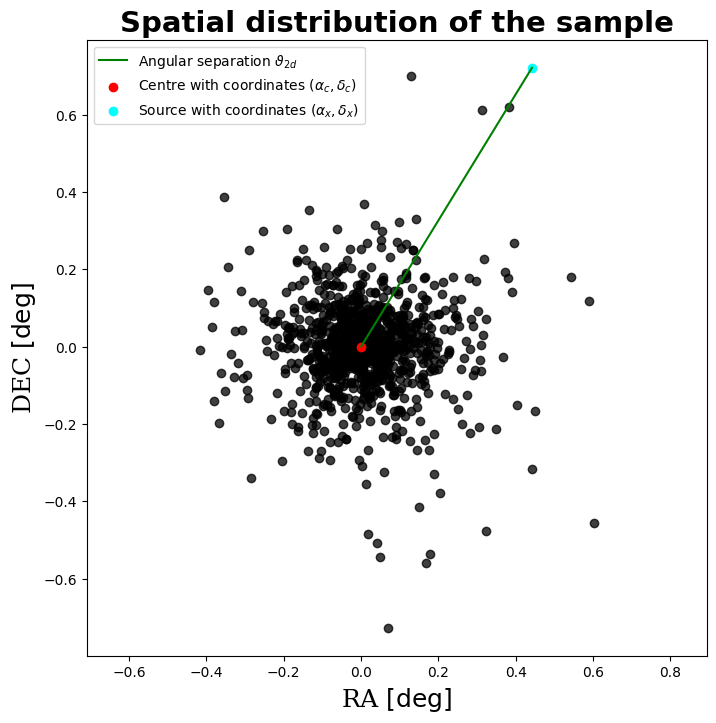

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.axis('equal')
plt.plot([0, 0.442], [0, 0.7210656659742464], c='green', label=r'Angular separation $\vartheta_{2d}$')
plt.scatter(ap_sample[2]-NGC6121.ra.value, ap_sample[3]-NGC6121.dec.value, color='black', alpha=0.75)
plt.scatter(0,0, c='red', label=r'Centre with coordinates $(\alpha_c, \delta_c)$')
plt.scatter(0.442, 0.7210656659742464, c='cyan', label=r'Source with coordinates $(\alpha_x, \delta_x)$')
#plt.xlim(-0.6,0.8)
#plt.ylim(-0.8,0.8)
plt.xlabel(r'RA $[{\rm deg}]$', fontdict=label_font)
plt.ylabel(r'DEC $[{\rm deg}]$', fontdict=label_font)
plt.title('Spatial distribution of the sample', fontdict=title_font)
plt.legend(loc='best')

HST data check

In [ ]:
s_tangential          = np.array([0.583, 0.538, 0.483, 0.592, 0.535, 0.583]) *(u.mas/u.yr)
s_radial              = np.array([0.588, 0.577, 0.635, 0.498, 0.564, 0.558]) *(u.mas/u.yr)
s_tot                 = np.array([0.582, 0.556, 0.562, 0.546, 0.543, 0.568]) *(u.mas/u.yr)
mean_radial_distance = np.array([13.4995, 29.6449, 46.1010, 62.5542, 79.6761, 106.7347])*u.arcsec
mean_radial_distance = mean_radial_distance.to(u.deg)

st_kms = s_tangential.to(u.rad/u.s) * D /u.rad
sr_kms = s_radial.to(u.rad/u.s) * D /u.rad
stot_kms = s_tot.to(u.rad/u.s) * D /u.rad

R2D = np.tan(mean_radial_distance.to(u.rad))*NGC6121.distance.to(u.pc)

In [ ]:
print(st_kms)
print(sr_kms)
print(stot_kms)
print(R2D)

[5.11559811 4.72074063 4.23813703 5.19456961 4.69441679 5.11559811] km / s
[5.15947117 5.06295045 5.57187788 4.36975619 4.94888051 4.89623284] km / s
[5.1068235  4.87868362 4.93133129 4.79093751 4.76461368 4.98397895] km / s
[0.12114318 0.26603041 0.41370583 0.56135523 0.71500549 0.95782674] pc


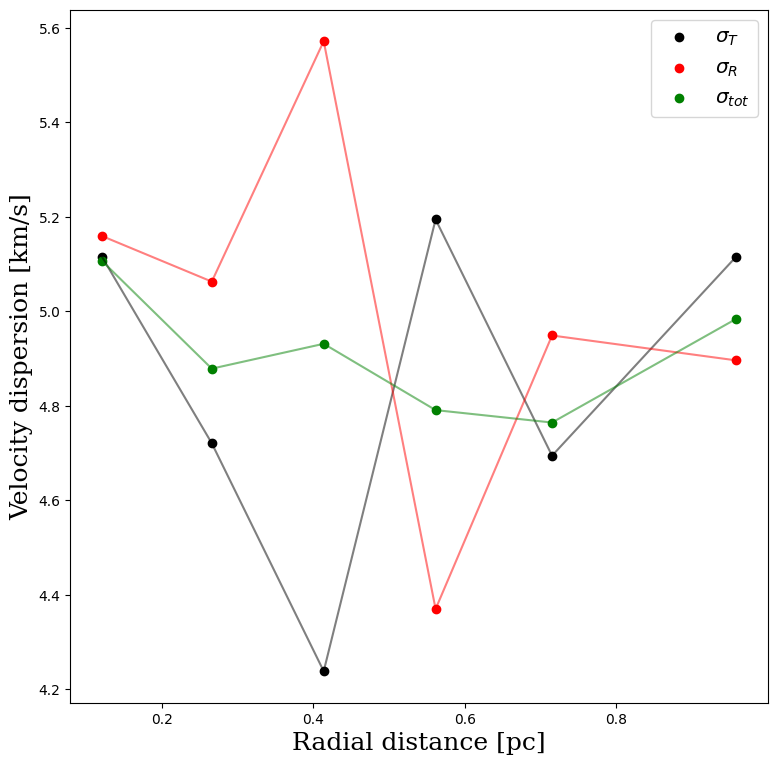

In [ ]:
plt.figure(figsize=(9,9))
plt.scatter(R2D, st_kms, c='black', label=r'$\sigma_T$')
plt.scatter(R2D, sr_kms, c='red', label=r'$\sigma_R$')
plt.scatter(R2D, stot_kms, c='green', label=r'$\sigma_{tot}$')
plt.plot(R2D, st_kms, c='black', alpha=0.5)
plt.plot(R2D, sr_kms, c='red', alpha=0.5)
plt.plot(R2D, stot_kms, c='green', alpha=0.5)
plt.xlabel('Radial distance [pc]', fontdict=label_font)
plt.ylabel('Velocity dispersion [km/s]', fontdict=label_font)
plt.legend(loc='best', fontsize='x-large')

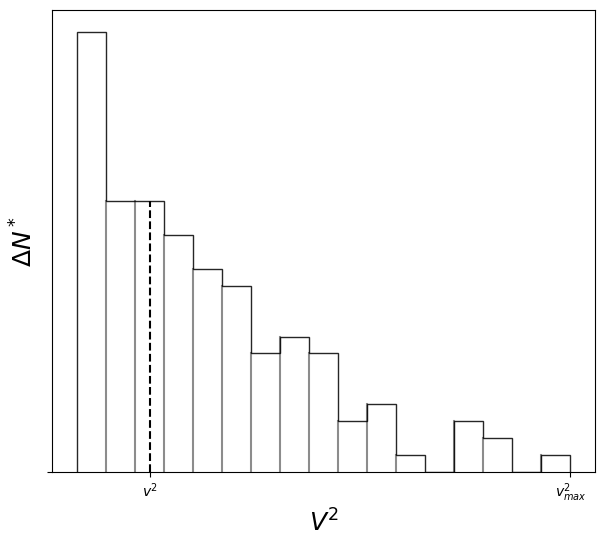

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))
mh = plt.hist(mShell[1], bins=mbin, color='black', alpha=0.85, label=r'$N_b$={:d}'.format(mbin), histtype='step')
names = ['',r'$v^2$', r'$v^2_{max}$']
values = [-9.871, (mh[1][2]+mh[1][3])*0.5, mh[1].max()]
#ax.text(mShell[1].max()/3, mh[0].max()/2, r'$<v^2>$ = {:.2f}$\pm${:.2f} km$^2/$s$^2$'.format(np.average(mShell[1]), np.sqrt(sum(i*i for i in mShell[2]))/len(mShell[2])), fontdict=label_font)
plt.xticks(values, names)
plt.yticks([0],[''])
plt.xlabel(r'$V^2$', fontdict=label_font)
plt.ylabel(r'$\Delta N^*$', fontdict=label_font)
plt.plot([(mh[1][2]+mh[1][3])*0.5,(mh[1][2]+mh[1][3])*0.5], [0, mh[0][2]], linestyle='--', color='black')
for i in range (1, mbin):
  plt.plot([mh[1][i],mh[1][i]], [0, mh[0][i]], color='black', alpha=0.45)
#plt.title(r'$N_T$ = {:d}'.format(len(mShell[0])), fontdict=title_font)
#plt.legend(fontsize='x-large')
output.clear()

(-1.0, 5.5)

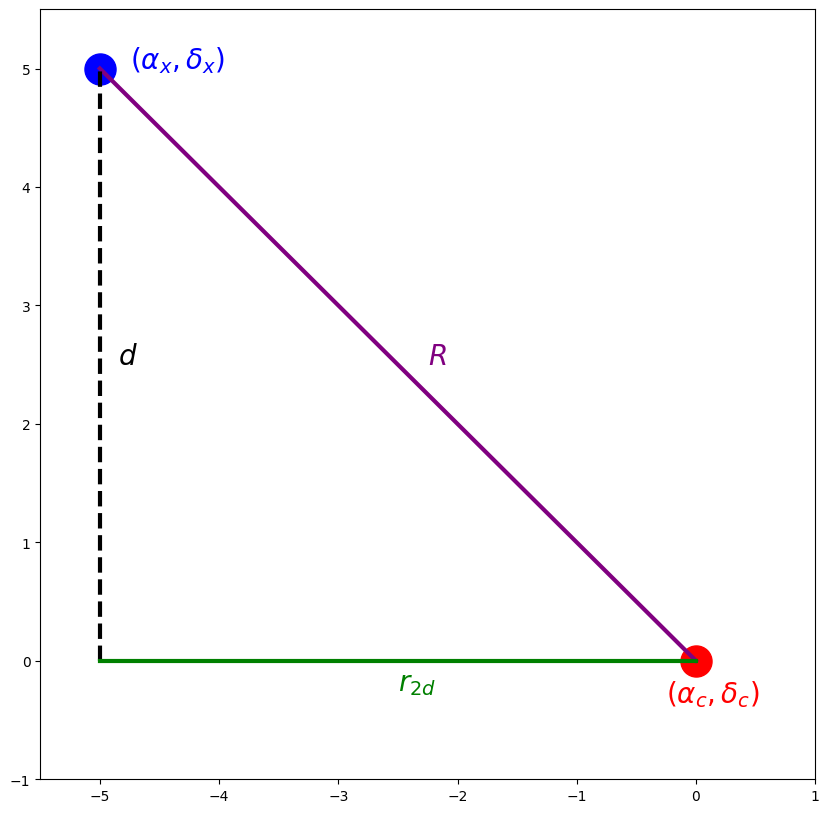

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
#ax.set_facecolor((0.9,0.9,0.9))
plt.plot([0,-5], [0,5], c='purple', linewidth=3)
plt.plot([-5,-5], [0,5], c='black', linestyle='--', linewidth=3)
plt.plot([-5, 0], [0, 0], c='green', linewidth=3)
plt.scatter(-5,5, color='blue', s=500)
plt.scatter(0,0, color='red', s=500)
ax.text(-4.75, 5, r'$(\alpha_x, \delta_x)$', color='blue', fontsize=20)
ax.text(-.250, -0.35, r'$(\alpha_c, \delta_c)$', color='red', fontsize=20)
ax.text(-2.5, -0.25, r'$r_{2d}$', color='green', fontsize=20)
ax.text(-4.85, 2.5, r'$d$', color='black', fontsize=20)
ax.text(-2.25, 2.5, r'$R$', color='purple', fontsize=20)
plt.xlim(-5.5, 1)
plt.ylim(-1, 5.5)